***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Test on Well-Formed Set (Factorial, Sample)


*Created:* March 3, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [7]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [8]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [9]:
def layer_wise_train(input_x,param_xy,param_yx,lr,perturb):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    if perturb == True:
        output_y = (output_y + (torch.rand(output_y.size(),device=dev) < 1/4).long()).fmod(2)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [10]:
def wake_phase(Phi,Theta,data,lr,dev,perturb):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [11]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [12]:
def wake_phase_update(Phi,Theta,data,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,)
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb=False)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [13]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,perturb=False)
        input_x = output_y
    return Phi, Loss

In [14]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [15]:
def sleep_phase_update(Phi,Theta,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,1,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
        # update cached items
        T['Layer'+str(i-1)] = (T['Layer'+str(i-1)] + output_y.reshape(-1,)*Eta[i-1])/(1+Eta[i-1])
    return Phi, Loss, T

In [16]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [17]:
def decimalize_np(bnr):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger numpy array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = \sigma\Big(\sum_{i=1}^n \mathrm{w}_{ij} \mathrm{x}_i - \sum_{i=1}^n\mathrm{x}_i^2 \cdot \gamma \big(p_j - \mathrm{y}_j\big)\Big)
\end{equation}
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [20]:
def increment(input_x, param, lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilona
    """
    linear = torch.matmul(param,input_x.type(torch.float)) # (n_y,batch_size)
    p = sigmoid(linear) # (n_y,batch_size)
    linear_update_0 = linear - input_x.sum(axis=0,keepdim=True)*lr*p
    linear_update_1 = linear - input_x.sum(axis=0,keepdim=True)*lr*(p-1)
    p_add_0 = sigmoid(linear_update_0)
    p_add_1 = sigmoid(linear_update_1)
    eps0 = (p - p_add_0)/(p+1e-8)  # (n_y,batch_size)
    eps1 = (p - p_add_1)/(p-1+1e-8)
    eps = (eps0 + eps1)/2
#     print(eps0,eps1)
    eps = eps.mean()
    return eps

In [21]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [22]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [23]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [24]:
def KL_divergence_inclusive(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*torch.where(q != 0, torch.log(q), 0)).sum() # q=0, log(q)=0
    else:
        raise Exception('Dimension error')
    return D_KL

In [25]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [26]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [27]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [28]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

### 1. $H(Y|x)$

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [29]:
def conditional_entropy(x,param,eps,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    H_Yx -- conditional entropy H_Yx at output layer Y, torch tensor of shape (2, n_y)
    """
    q = one_step_forward(x,param).reshape(-1,) # (n_y,)
    n_y = len(q)
    q_add = torch.zeros(2,n_y,device=dev) # p_j+1 of y_j = 0 (row1) and y_j = 1 (row2)
    q_add[0,:] = (1-eps) * q
    q_add[1,:] = (1-eps) * q + eps
    H_Yx = -(q_add*log(q_add) + (1-q_add)*log(1-q_add)) # (2,n_y)
    return H_Yx

### 2. $H(Y)_{ft}$

\begin{equation}
\mathbf{t} = \begin{pmatrix}
   \mathrm{p_1};&  \mathrm{p_2};&  \ldots;&  \mathrm{p_m}
    \end{pmatrix} 
\end{equation}
$\mathrm{p_j}$'s are Bernoulli probabilities.

\begin{equation}
    \mathrm{p_j}^{+1}(\mathrm{y}_j) = \left \{
    \begin{array}{ll}
     \frac{\mathrm{p_j} + \eta}{1+\eta},  &  \text{if } \mathrm{y}_j = 1\\
     \frac{\mathrm{p_j}}{1+\eta},   & \text{if } \mathrm{y}_j = 0
    \end{array}
    \right. \label{epsilon modify}
\end{equation}

In [30]:
def factorial_entropy(t,eta,dev):
    """
    Arguments:
    t -- Multi-variate Bernoulli distribution (p_1;p_2;...p_{n_y}), torch tensor of shape (n_y,)
    eta -- eta, hyperparameter of eta = eps/(1-eps)
    dev -- device
    
    Returns:
    H_ft -- factorial entropy H_ft at output layer Y, torch tensor of shape (2,n_y)
    """
    n_y = len(t)
    p_add = torch.zeros(2,n_y,device=dev) # p+1 of y_j = 0 (row1) and y_j = 1 (row2)
    p_add[0,:] = t/(1+eta)
    p_add[1,:] = (t+eta)/(1+eta)
    H_ft = -(p_add*log(p_add) + (1-p_add)*log(1-p_add)) # (2,n_y)
    return H_ft

In [31]:
def MI_max(I):
    """
    Argument: I -- mutual information, torch tensor of shape (2,n_y)
    Return: index -- sampled index, torch tensor of shape (n_y,)
    """
    index = I.argmax(dim=0)
    return index

In [32]:
def MI_train(input_x,param_xy,param_yx,lr,H_Y,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,1)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    H_Y -- entropy H(Y). Comnination of H_ct_state and H_ft_state
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # H_Yx
    H_Yx = conditional_entropy(input_x,param_xy,eps,dev) # (2**n_y,)

    # Compute mutual information
    I = H_Y - H_Yx
   
    # Maximum I
    output_y = MI_max(I).reshape(-1,1)  # (n_y,1)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return I, output_y, param_yx, grad, loss

In [33]:
def wake_phase_MI(Phi,Theta,data,lr,T,Epsilon,Eta,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        # H_ft
        H_Y = factorial_entropy(T['Layer'+str(i+1)],Eta[i],dev)

        # layer-wise training
        I, output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        MI_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,H_Y,Epsilon[i],dev)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [34]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    Delta -- hyperparameter O(eta/2^(m-1)), torch tensor of shape (n_layer-2,)
    """
    T = {}
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
        
        y_sample = Recog_sample["Layer_" + str(i+1)] #(n_y, batch_size)
        T['Layer'+str(i+1)] = y_sample.sum(axis=1)/batch_size
        
    Eta = Epsilon/(1-Epsilon) # H_ft; eta = eps/(1-eps)
    return T,Epsilon,Eta

## Data & Model

In [35]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [36]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [37]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_layer = len(n_dz)
n_d = n_dz[0]

In [38]:
well_formed = well_formed_generate(n_d)
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)

In [39]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [40]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [41]:
data_dist.sum()

tensor(1.0000)

In [42]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Data_D_KL',
 'Gen_D_KL',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3',
 'Gen_I_Layer_4']

In [43]:
len(col_list)

28

In [44]:
Analytic_well_formed_ws_online = pd.DataFrame(columns=col_list)
Analytic_well_formed_ws_online

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4


In [45]:
Phi,Theta = para_init(n_dz,dev)

### 1. Train with Wake-Sleep

In [ ]:
para = np.load('Parameters_well_formed_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [59]:
Analytic_well_formed_ws_online_continue = pd.read_csv('Analytic_well_formed_ws_online.csv', sep=",")
Analytic_well_formed_ws_online_continue

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.477162,0.608568,0.606603,0.592774,0.630917,0.464304,0.591105,0.588899,0.600768,3.244853,...,0.054938,7.077967,3.539952,3.953573,2.624095,1.505059,0.255339,0.148209,0.143978,0.127769
1,0.165550,0.222715,0.170283,0.215233,0.549830,0.226880,0.242490,0.176612,0.220423,2.910059,...,0.020334,7.210179,1.923169,1.440595,1.142938,0.672448,0.855700,0.114265,0.054400,0.053027
2,0.095268,0.078271,0.103717,0.138578,0.527883,0.206115,0.071097,0.097267,0.142885,2.870363,...,0.010310,7.329045,2.120772,0.915846,0.717171,0.519331,1.473279,0.062809,0.027192,0.027083
3,0.057512,0.032837,0.028669,0.034812,0.536871,0.151536,0.029915,0.022513,0.032624,2.216398,...,0.000990,6.681179,1.168330,0.185757,0.143927,0.112217,0.838982,0.003814,0.001400,0.004099
4,0.051279,0.022153,0.105351,0.014199,0.511674,0.181445,0.013579,0.104045,0.017790,1.471914,...,0.002230,7.224878,1.719337,0.074484,0.583950,0.064498,1.570638,0.002188,0.002704,0.002171
5,0.053084,0.091922,0.030859,0.033144,0.510217,0.173529,0.108264,0.039354,0.041337,2.118231,...,0.001530,7.036873,1.707897,0.726919,0.166233,0.105873,1.378877,0.057547,0.003458,0.002963
6,0.060100,0.017492,0.025061,0.019724,0.503924,0.195119,0.022809,0.025707,0.034752,1.752988,...,0.000307,7.299419,1.786663,0.237205,0.173930,0.070385,1.696158,0.011003,0.000872,0.001134
7,0.050100,0.006322,0.012269,0.035599,0.505968,0.182763,0.008357,0.014671,0.036716,1.489761,...,0.000513,6.876869,1.666472,0.067381,0.084214,0.079314,1.494292,0.002184,0.000326,0.001834
8,0.031755,0.007232,0.086452,0.025562,0.496759,0.175561,0.008249,0.079634,0.039151,3.242994,...,0.001882,6.648097,1.387494,0.054807,0.266315,0.089557,1.395724,0.002360,0.000537,0.003226
9,0.057800,0.008895,0.007203,0.036662,0.490554,0.200283,0.009381,0.008495,0.033395,2.323439,...,0.000241,7.001970,2.155481,0.046434,0.058112,0.096077,1.702484,0.002703,0.000166,0.001711


In [60]:
batch_size = 1
lr = 0.1
epoch = 1500
gen_batch_size = 100000
n_data

905

In [61]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(n_data):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
        values_g,counts_g = np.unique(decimalize_np(gen_data),return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=torch.from_numpy(counts_g).to(dev)/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_well_formed_ws_online_continue.loc[len(Analytic_well_formed_ws_online_continue)] = stat

Loss_wake: tensor([0.0000, 0.0220, 0.0012, 0.0047, 0.0663])     Loss_sleep: tensor([4.8575e-01, 1.7551e-01, 1.0992e-04, 1.4231e-04, 6.5815e-02])
Loss_wake: tensor([0.0000, 0.0267, 0.0001, 0.0034, 0.0524])     Loss_sleep: tensor([0.4841, 0.1863, 0.0028, 0.0018, 0.0530])
Loss_wake: tensor([0.0000, 0.0274, 0.0014, 0.0002, 0.0649])     Loss_sleep: tensor([0.4793, 0.1887, 0.0024, 0.0067, 0.0593])
Loss_wake: tensor([0.0000, 0.0359, 0.0016, 0.0002, 0.0422])     Loss_sleep: tensor([4.7398e-01, 2.0326e-01, 1.3840e-03, 1.5052e-04, 3.9392e-02])
Loss_wake: tensor([0.0000, 0.0358, 0.0045, 0.0018, 0.0344])     Loss_sleep: tensor([4.6701e-01, 2.0881e-01, 3.7323e-03, 1.1982e-04, 2.0866e-02])
Loss_wake: tensor([0.0000, 0.0223, 0.0013, 0.0001, 0.0211])     Loss_sleep: tensor([4.7963e-01, 1.8591e-01, 2.2251e-03, 1.1518e-04, 2.2331e-02])
Loss_wake: tensor([0.0000, 0.0323, 0.0011, 0.0001, 0.0321])     Loss_sleep: tensor([0.4738, 0.1993, 0.0014, 0.0018, 0.0318])
Loss_wake: tensor([0.0000, 0.0200, 0.0027, 0.

Loss_wake: tensor([0.0000, 0.0293, 0.0032, 0.0036, 0.0138])     Loss_sleep: tensor([0.4482, 0.2273, 0.0022, 0.0020, 0.0260])
Loss_wake: tensor([0.0000, 0.0297, 0.0022, 0.0034, 0.0214])     Loss_sleep: tensor([0.4415, 0.2311, 0.0024, 0.0017, 0.0166])
Loss_wake: tensor([0.0000, 0.0351, 0.0021, 0.0017, 0.0192])     Loss_sleep: tensor([4.4562e-01, 2.3024e-01, 2.5679e-03, 1.3973e-04, 2.2228e-02])
Loss_wake: tensor([0.0000, 0.0342, 0.0011, 0.0017, 0.0271])     Loss_sleep: tensor([4.4507e-01, 2.3520e-01, 4.8974e-03, 1.3645e-04, 2.5575e-02])
Loss_wake: tensor([0.0000, 0.0266, 0.0014, 0.0001, 0.0210])     Loss_sleep: tensor([4.4599e-01, 2.2992e-01, 2.1397e-04, 1.2307e-04, 1.8958e-02])
Loss_wake: tensor([0.0000, 0.0359, 0.0019, 0.0001, 0.0273])     Loss_sleep: tensor([4.5027e-01, 2.3370e-01, 1.2612e-03, 1.3102e-04, 3.1695e-02])
Loss_wake: tensor([0.0000, 0.0289, 0.0020, 0.0001, 0.0291])     Loss_sleep: tensor([4.4585e-01, 2.3023e-01, 4.8239e-03, 1.2062e-04, 2.6987e-02])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0220, 0.0002, 0.0004, 0.0238])     Loss_sleep: tensor([4.4156e-01, 2.2820e-01, 2.6345e-03, 3.5973e-04, 8.6976e-03])
Loss_wake: tensor([0.0000, 0.0263, 0.0012, 0.0049, 0.0191])     Loss_sleep: tensor([0.4427, 0.2273, 0.0035, 0.0035, 0.0100])
Loss_wake: tensor([0.0000, 0.0207, 0.0033, 0.0003, 0.0118])     Loss_sleep: tensor([4.3532e-01, 2.3164e-01, 2.7438e-04, 1.8125e-03, 2.0879e-02])
Loss_wake: tensor([0.0000, 0.0261, 0.0029, 0.0003, 0.0107])     Loss_sleep: tensor([0.4415, 0.2282, 0.0012, 0.0049, 0.0117])
Loss_wake: tensor([0.0000, 0.0271, 0.0013, 0.0034, 0.0179])     Loss_sleep: tensor([4.3854e-01, 2.2671e-01, 3.6185e-03, 3.2772e-04, 1.9157e-02])
Loss_wake: tensor([0.0000, 0.0176, 0.0046, 0.0033, 0.0107])     Loss_sleep: tensor([0.4403, 0.2317, 0.0025, 0.0062, 0.0081])
Loss_wake: tensor([0.0000, 0.0188, 0.0034, 0.0018, 0.0120])     Loss_sleep: tensor([4.3954e-01, 2.3397e-01, 2.5014e-04, 1.0686e-02, 1.1230e-02])
Loss_wake: tensor([0.0000, 0.0216, 0.0002, 0.

Loss_wake: tensor([0.0000, 0.0130, 0.0073, 0.0068, 0.0031])     Loss_sleep: tensor([0.4329, 0.2322, 0.0052, 0.0192, 0.0005])
Loss_wake: tensor([0.0000, 0.0201, 0.0047, 0.0152, 0.0089])     Loss_sleep: tensor([0.4375, 0.2316, 0.0033, 0.0133, 0.0031])
Loss_wake: tensor([0.0000, 0.0238, 0.0056, 0.0124, 0.0004])     Loss_sleep: tensor([0.4376, 0.2310, 0.0040, 0.0179, 0.0005])
Loss_wake: tensor([0.0000, 0.0238, 0.0064, 0.0197, 0.0004])     Loss_sleep: tensor([4.4194e-01, 2.2980e-01, 8.0510e-03, 2.2000e-02, 4.3677e-04])
Loss_wake: tensor([0.0000, 0.0200, 0.0111, 0.0341, 0.0058])     Loss_sleep: tensor([4.3417e-01, 2.3039e-01, 1.7533e-02, 2.7370e-02, 4.1331e-04])
Loss_wake: tensor([0.0000, 0.0180, 0.0052, 0.0284, 0.0031])     Loss_sleep: tensor([0.4364, 0.2300, 0.0080, 0.0310, 0.0031])
Loss_wake: tensor([0.0000, 0.0234, 0.0069, 0.0292, 0.0034])     Loss_sleep: tensor([0.4332, 0.2362, 0.0066, 0.0269, 0.0034])
Loss_wake: tensor([0.0000, 0.0258, 0.0062, 0.0139, 0.0065])     Loss_sleep: tensor([0

Loss_wake: tensor([0.0000, 0.0242, 0.0051, 0.0120, 0.0032])     Loss_sleep: tensor([0.4299, 0.2503, 0.0045, 0.0067, 0.0067])
Loss_wake: tensor([0.0000, 0.0450, 0.0069, 0.0088, 0.0034])     Loss_sleep: tensor([0.4218, 0.2698, 0.0086, 0.0061, 0.0064])
Loss_wake: tensor([0.0000, 0.0403, 0.0072, 0.0094, 0.0027])     Loss_sleep: tensor([0.4267, 0.2767, 0.0038, 0.0051, 0.0005])
Loss_wake: tensor([0.0000, 0.0442, 0.0052, 0.0124, 0.0032])     Loss_sleep: tensor([0.4252, 0.2707, 0.0070, 0.0081, 0.0005])
Loss_wake: tensor([0.0000, 0.0659, 0.0061, 0.0052, 0.0058])     Loss_sleep: tensor([0.4242, 0.2963, 0.0115, 0.0110, 0.0031])
Loss_wake: tensor([0.0000, 0.0419, 0.0085, 0.0084, 0.0060])     Loss_sleep: tensor([0.4250, 0.2696, 0.0079, 0.0094, 0.0031])
Loss_wake: tensor([0.0000, 0.0263, 0.0076, 0.0079, 0.0060])     Loss_sleep: tensor([0.4301, 0.2488, 0.0096, 0.0069, 0.0031])
Loss_wake: tensor([0.0000, 0.0362, 0.0136, 0.0070, 0.0032])     Loss_sleep: tensor([0.4245, 0.2606, 0.0117, 0.0056, 0.0114])


Loss_wake: tensor([0.0000, 0.0213, 0.0004, 0.0585, 0.0001])     Loss_sleep: tensor([0.4318, 0.2366, 0.0036, 0.0547, 0.0064])
Loss_wake: tensor([0.0000, 0.0142, 0.0043, 0.0204, 0.0029])     Loss_sleep: tensor([4.3178e-01, 2.3471e-01, 1.4239e-03, 1.9129e-02, 3.7194e-04])
Loss_wake: tensor([0.0000, 0.0144, 0.0013, 0.0137, 0.0040])     Loss_sleep: tensor([4.3266e-01, 2.3404e-01, 3.5668e-03, 1.6207e-02, 3.5754e-04])
Loss_wake: tensor([0.0000, 0.0171, 0.0011, 0.0141, 0.0032])     Loss_sleep: tensor([4.3189e-01, 2.3265e-01, 3.5262e-03, 1.3067e-02, 3.4429e-04])
Loss_wake: tensor([0.0000, 0.0170, 0.0003, 0.0135, 0.0001])     Loss_sleep: tensor([4.3736e-01, 2.3604e-01, 1.2167e-03, 1.4383e-02, 3.3209e-04])
Loss_wake: tensor([0.0000, 0.0230, 0.0018, 0.0150, 0.0001])     Loss_sleep: tensor([0.4329, 0.2429, 0.0012, 0.0181, 0.0031])
Loss_wake: tensor([0.0000, 0.0234, 0.0038, 0.0306, 0.0001])     Loss_sleep: tensor([4.3211e-01, 2.4168e-01, 3.5764e-03, 2.6185e-02, 3.2542e-04])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0197, 0.0010, 0.0061, 0.0033])     Loss_sleep: tensor([4.3232e-01, 2.3659e-01, 4.8561e-03, 8.3580e-03, 1.6788e-04])
Loss_wake: tensor([0.0000, 0.0317, 0.0003, 0.0085, 0.0001])     Loss_sleep: tensor([4.4211e-01, 2.3676e-01, 1.2769e-03, 3.2352e-03, 1.6498e-04])
Loss_wake: tensor([0.0000, 0.0306, 0.0017, 0.0104, 0.0033])     Loss_sleep: tensor([4.3889e-01, 2.3848e-01, 2.3536e-03, 9.6169e-03, 1.6217e-04])
Loss_wake: tensor([0.0000, 0.0391, 0.0013, 0.0068, 0.0032])     Loss_sleep: tensor([0.4453, 0.2381, 0.0014, 0.0090, 0.0032])
Loss_wake: tensor([0.0000, 0.0189, 0.0036, 0.0156, 0.0002])     Loss_sleep: tensor([4.3697e-01, 2.3637e-01, 2.3229e-03, 1.3915e-02, 1.6507e-04])
Loss_wake: tensor([0.0000, 0.0178, 0.0002, 0.0202, 0.0002])     Loss_sleep: tensor([4.3310e-01, 2.3581e-01, 2.3723e-03, 2.2026e-02, 1.6220e-04])
Loss_wake: tensor([0.0000, 0.0149, 0.0022, 0.0181, 0.0001])     Loss_sleep: tensor([4.3233e-01, 2.3489e-01, 2.5454e-04, 1.7214e-02, 3.2171e-03])
Loss_

Loss_wake: tensor([0.0000, 0.0100, 0.0011, 0.0129, 0.0001])     Loss_sleep: tensor([0.4334, 0.2301, 0.0026, 0.0198, 0.0066])
Loss_wake: tensor([0.0000, 0.0111, 0.0023, 0.0193, 0.0001])     Loss_sleep: tensor([4.3413e-01, 2.2943e-01, 2.0900e-04, 1.3599e-02, 1.4026e-04])
Loss_wake: tensor([0.0000, 0.0136, 0.0011, 0.0200, 0.0001])     Loss_sleep: tensor([0.4354, 0.2305, 0.0037, 0.0175, 0.0034])
Loss_wake: tensor([0.0000, 0.0168, 0.0039, 0.0115, 0.0001])     Loss_sleep: tensor([4.3817e-01, 2.3007e-01, 6.4032e-03, 9.4407e-03, 1.4164e-04])
Loss_wake: tensor([0.0000, 0.0218, 0.0035, 0.0157, 0.0001])     Loss_sleep: tensor([4.4032e-01, 2.3258e-01, 2.4199e-03, 9.1795e-03, 1.3970e-04])
Loss_wake: tensor([0.0000, 0.0177, 0.0018, 0.0135, 0.0001])     Loss_sleep: tensor([4.3482e-01, 2.3217e-01, 2.4961e-03, 1.6286e-02, 1.3782e-04])
Loss_wake: tensor([0.0000, 0.0118, 0.0026, 0.0171, 0.0001])     Loss_sleep: tensor([4.3455e-01, 2.3263e-01, 3.0876e-04, 1.7431e-02, 3.3359e-03])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0146, 0.0121, 0.0879, 0.0003])     Loss_sleep: tensor([4.3372e-01, 2.3263e-01, 8.9701e-03, 8.4629e-02, 2.6985e-04])
Loss_wake: tensor([0.0000, 0.0143, 0.0060, 0.0834, 0.0003])     Loss_sleep: tensor([0.4328, 0.2323, 0.0092, 0.0779, 0.0031])
Loss_wake: tensor([0.0000, 0.0138, 0.0032, 0.0638, 0.0035])     Loss_sleep: tensor([4.3034e-01, 2.3484e-01, 5.5090e-03, 6.4314e-02, 2.6822e-04])
Loss_wake: tensor([0.0000, 0.0133, 0.0024, 0.0746, 0.0032])     Loss_sleep: tensor([4.3501e-01, 2.3094e-01, 4.7764e-03, 7.3062e-02, 2.5891e-04])
Loss_wake: tensor([0.0000, 0.0183, 0.0019, 0.0276, 0.0001])     Loss_sleep: tensor([0.4319, 0.2337, 0.0012, 0.0238, 0.0031])
Loss_wake: tensor([0.0000, 0.0141, 0.0041, 0.0416, 0.0032])     Loss_sleep: tensor([0.4349, 0.2311, 0.0051, 0.0389, 0.0058])
Loss_wake: tensor([0.0000, 0.0169, 0.0020, 0.0374, 0.0002])     Loss_sleep: tensor([4.3451e-01, 2.3592e-01, 2.8803e-03, 3.4963e-02, 2.8350e-04])
Loss_wake: tensor([0.0000, 0.0206, 0.0011, 0.

Loss_wake: tensor([0.0000e+00, 1.5229e-02, 1.0250e-03, 1.2730e-02, 6.9676e-05])     Loss_sleep: tensor([4.3183e-01, 2.3190e-01, 4.3022e-03, 1.2827e-02, 1.1960e-04])
Loss_wake: tensor([0.0000, 0.0160, 0.0046, 0.0107, 0.0035])     Loss_sleep: tensor([4.3352e-01, 2.3481e-01, 1.2575e-03, 7.0538e-03, 1.1818e-04])
Loss_wake: tensor([0.0000e+00, 1.4544e-02, 2.3219e-03, 1.3732e-02, 7.6217e-05])     Loss_sleep: tensor([0.4291, 0.2407, 0.0027, 0.0091, 0.0035])
Loss_wake: tensor([0.0000e+00, 1.5086e-02, 2.8696e-03, 7.4146e-03, 7.0926e-05])     Loss_sleep: tensor([4.3109e-01, 2.3747e-01, 2.0968e-03, 3.4329e-03, 1.1935e-04])
Loss_wake: tensor([0.0000, 0.0135, 0.0015, 0.0081, 0.0034])     Loss_sleep: tensor([4.3134e-01, 2.3715e-01, 3.6061e-03, 7.4786e-03, 1.1794e-04])
Loss_wake: tensor([0.0000e+00, 1.4039e-02, 1.0027e-03, 7.7755e-03, 8.4834e-05])     Loss_sleep: tensor([4.3237e-01, 2.3190e-01, 2.7892e-04, 1.1499e-02, 1.1656e-04])
Loss_wake: tensor([0.0000e+00, 1.2126e-02, 2.1088e-04, 1.0692e-02, 8.2

Loss_wake: tensor([0.0000, 0.0094, 0.0185, 0.0134, 0.0004])     Loss_sleep: tensor([4.2834e-01, 2.3136e-01, 1.9532e-02, 3.0873e-03, 1.2183e-04])
Loss_wake: tensor([0.0000, 0.0143, 0.0608, 0.0049, 0.0003])     Loss_sleep: tensor([0.4287, 0.2280, 0.0635, 0.0129, 0.0139])
Loss_wake: tensor([0.0000, 0.0153, 0.0203, 0.0050, 0.0032])     Loss_sleep: tensor([0.4318, 0.2350, 0.0208, 0.0099, 0.0034])
Loss_wake: tensor([0.0000, 0.0193, 0.0093, 0.0125, 0.0003])     Loss_sleep: tensor([0.4310, 0.2425, 0.0108, 0.0078, 0.0033])
Loss_wake: tensor([0.0000, 0.0226, 0.0078, 0.0067, 0.0003])     Loss_sleep: tensor([4.3259e-01, 2.4019e-01, 1.0167e-02, 9.8993e-03, 1.3860e-04])
Loss_wake: tensor([0.0000, 0.0181, 0.0094, 0.0029, 0.0003])     Loss_sleep: tensor([4.3118e-01, 2.3624e-01, 6.0379e-03, 5.4269e-03, 1.3669e-04])
Loss_wake: tensor([0.0000, 0.0142, 0.0105, 0.0075, 0.0033])     Loss_sleep: tensor([0.4334, 0.2340, 0.0088, 0.0036, 0.0034])
Loss_wake: tensor([0.0000, 0.0133, 0.0112, 0.0017, 0.0003])     L

Loss_wake: tensor([0.0000, 0.0131, 0.0021, 0.0003, 0.0002])     Loss_sleep: tensor([4.3068e-01, 2.3357e-01, 5.7288e-03, 2.7706e-04, 3.5686e-03])
Loss_wake: tensor([0.0000, 0.0127, 0.0031, 0.0019, 0.0002])     Loss_sleep: tensor([4.2802e-01, 2.3437e-01, 4.5015e-03, 2.4407e-04, 2.1161e-04])
Loss_wake: tensor([0.0000, 0.0166, 0.0032, 0.0002, 0.0037])     Loss_sleep: tensor([4.3197e-01, 2.3813e-01, 2.2331e-03, 3.2866e-03, 2.0662e-04])
Loss_wake: tensor([0.0000, 0.0140, 0.0043, 0.0017, 0.0002])     Loss_sleep: tensor([4.3529e-01, 2.3191e-01, 3.4916e-03, 1.7341e-03, 2.0190e-04])
Loss_wake: tensor([0.0000, 0.0143, 0.0050, 0.0033, 0.0065])     Loss_sleep: tensor([0.4354, 0.2263, 0.0026, 0.0032, 0.0035])
Loss_wake: tensor([0.0000, 0.0159, 0.0052, 0.0018, 0.0002])     Loss_sleep: tensor([4.3548e-01, 2.2808e-01, 6.1006e-03, 2.4781e-04, 1.9809e-04])
Loss_wake: tensor([0.0000, 0.0119, 0.0024, 0.0033, 0.0062])     Loss_sleep: tensor([4.2867e-01, 2.3238e-01, 3.7884e-03, 1.7030e-03, 1.9393e-04])
Loss_

Loss_wake: tensor([0.0000, 0.0451, 0.0035, 0.0002, 0.0065])     Loss_sleep: tensor([0.4198, 0.2725, 0.0014, 0.0017, 0.0068])
Loss_wake: tensor([0.0000, 0.0556, 0.0056, 0.0002, 0.0003])     Loss_sleep: tensor([0.4160, 0.2905, 0.0015, 0.0031, 0.0061])
Loss_wake: tensor([0.0000, 0.0720, 0.0013, 0.0081, 0.0003])     Loss_sleep: tensor([4.1193e-01, 3.0672e-01, 2.5867e-03, 1.7596e-03, 2.2839e-04])
Loss_wake: tensor([0.0000, 0.0437, 0.0014, 0.0031, 0.0035])     Loss_sleep: tensor([4.2560e-01, 2.7717e-01, 1.4157e-03, 3.1675e-03, 2.2268e-04])
Loss_wake: tensor([0.0000, 0.0617, 0.0027, 0.0046, 0.0002])     Loss_sleep: tensor([4.1656e-01, 2.9292e-01, 2.4430e-03, 1.6807e-03, 2.1728e-04])
Loss_wake: tensor([0.0000, 0.0371, 0.0054, 0.0003, 0.0035])     Loss_sleep: tensor([4.2864e-01, 2.6163e-01, 3.4984e-04, 4.4958e-03, 3.1478e-03])
Loss_wake: tensor([0.0000, 0.0306, 0.0013, 0.0018, 0.0032])     Loss_sleep: tensor([4.2987e-01, 2.5095e-01, 2.4370e-03, 2.8676e-04, 2.1885e-04])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0173, 0.0020, 0.0018, 0.0002])     Loss_sleep: tensor([0.4305, 0.2390, 0.0038, 0.0031, 0.0033])
Loss_wake: tensor([0.0000, 0.0199, 0.0048, 0.0031, 0.0067])     Loss_sleep: tensor([4.3255e-01, 2.3949e-01, 1.5248e-03, 3.6794e-03, 2.5569e-04])
Loss_wake: tensor([0.0000, 0.0131, 0.0030, 0.0016, 0.0002])     Loss_sleep: tensor([4.3156e-01, 2.3635e-01, 6.9810e-03, 4.6439e-03, 2.4919e-04])
Loss_wake: tensor([0.0000, 0.0144, 0.0026, 0.0016, 0.0033])     Loss_sleep: tensor([4.3035e-01, 2.3750e-01, 3.3190e-03, 2.3922e-04, 2.4302e-04])
Loss_wake: tensor([0.0000, 0.0218, 0.0017, 0.0062, 0.0033])     Loss_sleep: tensor([4.2526e-01, 2.4717e-01, 1.3285e-03, 1.6375e-03, 2.3717e-04])
Loss_wake: tensor([0.0000, 0.0157, 0.0035, 0.0003, 0.0066])     Loss_sleep: tensor([4.2898e-01, 2.3798e-01, 1.2756e-03, 2.2725e-04, 3.2467e-03])
Loss_wake: tensor([0.0000, 0.0155, 0.0057, 0.0046, 0.0036])     Loss_sleep: tensor([0.4288, 0.2390, 0.0056, 0.0016, 0.0062])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0161, 0.0030, 0.0057, 0.0034])     Loss_sleep: tensor([0.4303, 0.2374, 0.0013, 0.0075, 0.0032])
Loss_wake: tensor([0.0000, 0.0157, 0.0013, 0.0003, 0.0003])     Loss_sleep: tensor([4.3191e-01, 2.3853e-01, 2.3214e-03, 1.6391e-03, 3.6303e-04])
Loss_wake: tensor([0.0000, 0.0166, 0.0014, 0.0012, 0.0003])     Loss_sleep: tensor([4.3185e-01, 2.3714e-01, 3.2273e-04, 3.3876e-03, 6.5013e-03])
Loss_wake: tensor([0.0000, 0.0132, 0.0037, 0.0032, 0.0032])     Loss_sleep: tensor([0.4305, 0.2356, 0.0046, 0.0016, 0.0032])
Loss_wake: tensor([0.0000, 0.0098, 0.0025, 0.0019, 0.0037])     Loss_sleep: tensor([4.3156e-01, 2.2919e-01, 4.8330e-03, 3.8144e-04, 6.4754e-03])
Loss_wake: tensor([0.0000, 0.0111, 0.0026, 0.0002, 0.0002])     Loss_sleep: tensor([0.4333, 0.2335, 0.0016, 0.0018, 0.0036])
Loss_wake: tensor([0.0000, 0.0142, 0.0027, 0.0002, 0.0002])     Loss_sleep: tensor([4.3140e-01, 2.3559e-01, 2.4813e-04, 2.8441e-04, 3.5427e-03])
Loss_wake: tensor([0.0000, 0.0143, 0.0045, 0.

Loss_wake: tensor([0.0000, 0.0076, 0.0013, 0.0016, 0.0061])     Loss_sleep: tensor([0.4320, 0.2304, 0.0024, 0.0016, 0.0089])
Loss_wake: tensor([0.0000, 0.0099, 0.0027, 0.0018, 0.0061])     Loss_sleep: tensor([0.4318, 0.2301, 0.0047, 0.0058, 0.0061])
Loss_wake: tensor([0.0000, 0.0085, 0.0002, 0.0032, 0.0034])     Loss_sleep: tensor([0.4323, 0.2300, 0.0028, 0.0032, 0.0064])
Loss_wake: tensor([0.0000, 0.0096, 0.0019, 0.0032, 0.0063])     Loss_sleep: tensor([0.4319, 0.2295, 0.0012, 0.0033, 0.0007])
Loss_wake: tensor([0.0000, 0.0084, 0.0044, 0.0018, 0.0006])     Loss_sleep: tensor([0.4290, 0.2296, 0.0025, 0.0029, 0.0089])
Loss_wake: tensor([0.0000, 0.0096, 0.0010, 0.0050, 0.0006])     Loss_sleep: tensor([0.4333, 0.2315, 0.0035, 0.0031, 0.0060])
Loss_wake: tensor([0.0000, 0.0067, 0.0036, 0.0016, 0.0063])     Loss_sleep: tensor([0.4290, 0.2287, 0.0025, 0.0017, 0.0091])
Loss_wake: tensor([0.0000, 0.0084, 0.0012, 0.0018, 0.0145])     Loss_sleep: tensor([4.2817e-01, 2.3003e-01, 2.7578e-03, 3.274

Loss_wake: tensor([0.0000, 0.0224, 0.0025, 0.0020, 0.0087])     Loss_sleep: tensor([0.4367, 0.2356, 0.0022, 0.0018, 0.0035])
Loss_wake: tensor([0.0000, 0.0109, 0.0014, 0.0047, 0.0018])     Loss_sleep: tensor([0.4308, 0.2320, 0.0037, 0.0062, 0.0061])
Loss_wake: tensor([0.0000, 0.0084, 0.0027, 0.0003, 0.0064])     Loss_sleep: tensor([0.4332, 0.2295, 0.0033, 0.0073, 0.0033])
Loss_wake: tensor([0.0000, 0.0091, 0.0043, 0.0018, 0.0005])     Loss_sleep: tensor([0.4300, 0.2307, 0.0033, 0.0004, 0.0090])
Loss_wake: tensor([0.0000, 0.0090, 0.0010, 0.0021, 0.0032])     Loss_sleep: tensor([0.4304, 0.2304, 0.0024, 0.0032, 0.0059])
Loss_wake: tensor([0.0000, 0.0103, 0.0056, 0.0017, 0.0004])     Loss_sleep: tensor([0.4304, 0.2299, 0.0058, 0.0031, 0.0005])
Loss_wake: tensor([0.0000, 0.0109, 0.0040, 0.0002, 0.0061])     Loss_sleep: tensor([0.4315, 0.2312, 0.0027, 0.0031, 0.0033])
Loss_wake: tensor([0.0000, 0.0112, 0.0025, 0.0002, 0.0004])     Loss_sleep: tensor([0.4322, 0.2300, 0.0066, 0.0018, 0.0033])


Loss_wake: tensor([0.0000, 0.0158, 0.0160, 0.0138, 0.0062])     Loss_sleep: tensor([0.4370, 0.2267, 0.0138, 0.0139, 0.0032])
Loss_wake: tensor([0.0000, 0.0118, 0.0106, 0.0224, 0.0095])     Loss_sleep: tensor([4.3304e-01, 2.2559e-01, 8.3539e-03, 2.4036e-02, 3.7415e-04])
Loss_wake: tensor([0.0000, 0.0130, 0.0076, 0.0120, 0.0005])     Loss_sleep: tensor([4.3431e-01, 2.2803e-01, 8.0407e-03, 1.8026e-02, 3.6104e-04])
Loss_wake: tensor([0.0000, 0.0108, 0.0126, 0.0232, 0.0065])     Loss_sleep: tensor([0.4326, 0.2291, 0.0064, 0.0239, 0.0032])
Loss_wake: tensor([0.0000, 0.0154, 0.0231, 0.0251, 0.0036])     Loss_sleep: tensor([0.4350, 0.2250, 0.0322, 0.0180, 0.0061])
Loss_wake: tensor([0.0000, 0.0136, 0.0725, 0.0194, 0.0032])     Loss_sleep: tensor([0.4345, 0.2183, 0.0855, 0.0205, 0.0032])
Loss_wake: tensor([0.0000, 0.0180, 0.0542, 0.0234, 0.0005])     Loss_sleep: tensor([0.4369, 0.2132, 0.0729, 0.0196, 0.0061])
Loss_wake: tensor([0.0000, 0.0474, 0.0586, 0.0200, 0.0004])     Loss_sleep: tensor([4

Loss_wake: tensor([0.0000, 0.0070, 0.0001, 0.0065, 0.0034])     Loss_sleep: tensor([4.3057e-01, 2.2598e-01, 2.3081e-03, 7.3696e-03, 2.7613e-04])
Loss_wake: tensor([0.0000, 0.0085, 0.0012, 0.0070, 0.0003])     Loss_sleep: tensor([4.3105e-01, 2.2532e-01, 1.2142e-03, 9.2672e-03, 2.6883e-04])
Loss_wake: tensor([0.0000, 0.0106, 0.0017, 0.0046, 0.0002])     Loss_sleep: tensor([0.4317, 0.2266, 0.0017, 0.0045, 0.0065])
Loss_wake: tensor([0.0000, 0.0074, 0.0001, 0.0090, 0.0068])     Loss_sleep: tensor([4.3352e-01, 2.2594e-01, 1.4028e-04, 4.3850e-03, 6.3369e-03])
Loss_wake: tensor([0.0000, 0.0079, 0.0001, 0.0140, 0.0003])     Loss_sleep: tensor([0.4330, 0.2279, 0.0013, 0.0124, 0.0063])
Loss_wake: tensor([0.0000, 0.0055, 0.0001, 0.0128, 0.0034])     Loss_sleep: tensor([4.2874e-01, 2.2638e-01, 1.3835e-04, 1.1932e-02, 6.4837e-03])
Loss_wake: tensor([0.0000, 0.0099, 0.0011, 0.0030, 0.0066])     Loss_sleep: tensor([0.4314, 0.2258, 0.0017, 0.0055, 0.0034])
Loss_wake: tensor([0.0000, 0.0068, 0.0015, 0.

Loss_wake: tensor([0.0000e+00, 6.0246e-03, 7.0116e-05, 3.2324e-04, 1.9255e-04])     Loss_sleep: tensor([4.2910e-01, 2.2684e-01, 5.6128e-05, 1.7156e-03, 3.1586e-03])
Loss_wake: tensor([0.0000e+00, 9.2341e-03, 6.7377e-05, 3.0193e-03, 1.8876e-04])     Loss_sleep: tensor([4.3094e-01, 2.2738e-01, 5.7453e-05, 4.4225e-03, 2.4830e-04])
Loss_wake: tensor([0.0000, 0.0084, 0.0013, 0.0059, 0.0040])     Loss_sleep: tensor([4.3042e-01, 2.2477e-01, 5.3581e-05, 1.6575e-03, 2.4191e-04])
Loss_wake: tensor([0.0000, 0.0102, 0.0011, 0.0017, 0.0002])     Loss_sleep: tensor([4.2852e-01, 2.2711e-01, 5.0410e-05, 1.7338e-03, 3.1546e-03])
Loss_wake: tensor([0.0000, 0.0074, 0.0013, 0.0036, 0.0002])     Loss_sleep: tensor([4.3151e-01, 2.2577e-01, 1.2814e-03, 4.4717e-03, 2.4204e-04])
Loss_wake: tensor([0.0000e+00, 1.1618e-02, 9.4065e-05, 1.6740e-03, 1.5805e-04])     Loss_sleep: tensor([0.4313, 0.2273, 0.0014, 0.0030, 0.0067])
Loss_wake: tensor([0.0000e+00, 1.4140e-02, 8.8818e-05, 3.0461e-03, 6.3817e-03])     Loss_s

Loss_wake: tensor([0.0000e+00, 1.1244e-02, 6.5037e-05, 1.7012e-03, 3.5990e-03])     Loss_sleep: tensor([4.3297e-01, 2.3515e-01, 1.1846e-03, 2.8579e-04, 3.1342e-03])
Loss_wake: tensor([0.0000, 0.0130, 0.0011, 0.0030, 0.0002])     Loss_sleep: tensor([4.3426e-01, 2.3164e-01, 9.0307e-05, 1.7234e-03, 3.1192e-03])
Loss_wake: tensor([0.0000e+00, 1.2220e-02, 7.1502e-05, 1.8084e-03, 3.1659e-03])     Loss_sleep: tensor([4.3044e-01, 2.3391e-01, 8.0837e-05, 3.0139e-03, 2.6712e-04])
Loss_wake: tensor([0.0000, 0.0102, 0.0013, 0.0029, 0.0002])     Loss_sleep: tensor([4.3080e-01, 2.3001e-01, 1.1890e-03, 4.3725e-03, 2.5919e-04])
Loss_wake: tensor([0.0000, 0.0136, 0.0010, 0.0003, 0.0060])     Loss_sleep: tensor([4.3151e-01, 2.3217e-01, 8.7684e-05, 3.0918e-03, 3.1188e-03])
Loss_wake: tensor([0.0000, 0.0171, 0.0010, 0.0002, 0.0065])     Loss_sleep: tensor([4.2761e-01, 2.3670e-01, 1.4162e-03, 3.0098e-04, 2.5847e-04])
Loss_wake: tensor([0.0000, 0.0107, 0.0015, 0.0017, 0.0003])     Loss_sleep: tensor([4.3024

Loss_wake: tensor([0.0000, 0.0120, 0.0024, 0.0003, 0.0031])     Loss_sleep: tensor([0.4281, 0.2353, 0.0022, 0.0017, 0.0031])
Loss_wake: tensor([0.0000, 0.0110, 0.0015, 0.0002, 0.0031])     Loss_sleep: tensor([4.2972e-01, 2.3311e-01, 1.3968e-04, 2.2909e-04, 3.0967e-03])
Loss_wake: tensor([0.0000, 0.0094, 0.0010, 0.0018, 0.0069])     Loss_sleep: tensor([4.2853e-01, 2.3247e-01, 1.3666e-03, 2.1223e-04, 3.0840e-03])
Loss_wake: tensor([0.0000, 0.0086, 0.0001, 0.0017, 0.0062])     Loss_sleep: tensor([0.4297, 0.2295, 0.0012, 0.0034, 0.0035])
Loss_wake: tensor([0.0000, 0.0055, 0.0010, 0.0017, 0.0031])     Loss_sleep: tensor([4.2997e-01, 2.2767e-01, 1.1921e-04, 1.6650e-03, 2.7821e-04])
Loss_wake: tensor([0.0000, 0.0062, 0.0012, 0.0017, 0.0031])     Loss_sleep: tensor([4.3032e-01, 2.2991e-01, 1.0553e-04, 3.2273e-03, 3.4957e-03])
Loss_wake: tensor([0.0000, 0.0068, 0.0001, 0.0017, 0.0031])     Loss_sleep: tensor([4.2889e-01, 2.2753e-01, 1.1870e-03, 2.0814e-04, 3.1048e-03])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000e+00, 1.3418e-02, 9.1884e-05, 1.6634e-03, 1.4633e-04])     Loss_sleep: tensor([4.2651e-01, 2.3694e-01, 1.2433e-04, 2.0198e-04, 1.7823e-04])
Loss_wake: tensor([0.0000, 0.0118, 0.0024, 0.0001, 0.0033])     Loss_sleep: tensor([4.2905e-01, 2.3155e-01, 1.1675e-03, 3.1155e-03, 1.7496e-04])
Loss_wake: tensor([0.0000, 0.0059, 0.0001, 0.0001, 0.0032])     Loss_sleep: tensor([4.2856e-01, 2.3063e-01, 2.7368e-03, 2.0048e-04, 1.7182e-04])
Loss_wake: tensor([0.0000e+00, 9.7092e-03, 9.5715e-05, 1.2409e-04, 5.8928e-03])     Loss_sleep: tensor([4.2997e-01, 2.3105e-01, 1.2175e-04, 3.0489e-03, 9.5524e-03])
Loss_wake: tensor([0.0000e+00, 8.7545e-03, 8.3225e-05, 1.6496e-03, 2.9033e-04])     Loss_sleep: tensor([4.2992e-01, 2.3003e-01, 1.0306e-04, 2.0587e-04, 3.1728e-03])
Loss_wake: tensor([0.0000, 0.0070, 0.0025, 0.0017, 0.0065])     Loss_sleep: tensor([4.2884e-01, 2.3056e-01, 1.5484e-03, 3.2367e-03, 1.9455e-04])
Loss_wake: tensor([0.0000, 0.0072, 0.0011, 0.0017, 0.0030])     Loss_s

Loss_wake: tensor([0.0000, 0.0111, 0.0026, 0.0039, 0.0002])     Loss_sleep: tensor([4.3202e-01, 2.3510e-01, 1.4046e-03, 8.4546e-03, 2.0084e-04])
Loss_wake: tensor([0.0000, 0.0108, 0.0001, 0.0039, 0.0002])     Loss_sleep: tensor([0.4274, 0.2380, 0.0012, 0.0044, 0.0065])
Loss_wake: tensor([0.0000, 0.0122, 0.0001, 0.0028, 0.0037])     Loss_sleep: tensor([4.2929e-01, 2.3250e-01, 1.1560e-03, 1.7618e-03, 2.0699e-04])
Loss_wake: tensor([0.0000, 0.0079, 0.0023, 0.0016, 0.0001])     Loss_sleep: tensor([4.3189e-01, 2.3053e-01, 1.1470e-03, 3.0942e-03, 2.0237e-04])
Loss_wake: tensor([0.0000, 0.0105, 0.0011, 0.0083, 0.0002])     Loss_sleep: tensor([4.3368e-01, 2.3319e-01, 1.0707e-04, 3.7124e-03, 1.9798e-04])
Loss_wake: tensor([0.0000, 0.0096, 0.0020, 0.0046, 0.0025])     Loss_sleep: tensor([0.4308, 0.2322, 0.0012, 0.0052, 0.0035])
Loss_wake: tensor([0.0000, 0.0147, 0.0012, 0.0016, 0.0020])     Loss_sleep: tensor([4.2776e-01, 2.3518e-01, 2.1392e-03, 4.9878e-03, 1.9462e-04])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000e+00, 8.2014e-03, 3.3221e-05, 1.5528e-03, 3.2871e-03])     Loss_sleep: tensor([4.2951e-01, 2.3061e-01, 5.0784e-05, 2.3537e-04, 1.4362e-04])
Loss_wake: tensor([0.0000, 0.0084, 0.0013, 0.0053, 0.0002])     Loss_sleep: tensor([0.4305, 0.2301, 0.0012, 0.0018, 0.0034])
Loss_wake: tensor([0.0000, 0.0069, 0.0012, 0.0002, 0.0001])     Loss_sleep: tensor([4.2947e-01, 2.2850e-01, 5.6373e-05, 1.7603e-03, 1.4430e-04])
Loss_wake: tensor([0.0000e+00, 7.2101e-03, 5.1291e-05, 1.5613e-03, 1.3877e-04])     Loss_sleep: tensor([4.3001e-01, 2.2927e-01, 5.3498e-05, 1.5818e-03, 6.6990e-03])
Loss_wake: tensor([0.0000e+00, 6.9143e-03, 4.6682e-05, 1.8416e-04, 1.3005e-04])     Loss_sleep: tensor([4.2820e-01, 2.2999e-01, 5.0523e-05, 1.5603e-03, 1.5016e-04])
Loss_wake: tensor([0.0000e+00, 8.6075e-03, 4.5160e-05, 1.5841e-04, 7.0675e-03])     Loss_sleep: tensor([4.3299e-01, 2.2733e-01, 4.9064e-05, 3.1144e-03, 1.4804e-04])
Loss_wake: tensor([0.0000e+00, 8.4461e-03, 4.0910e-05, 3.6421e-03, 3.3

Loss_wake: tensor([0.0000e+00, 6.0277e-03, 3.5879e-05, 3.1081e-03, 3.6312e-03])     Loss_sleep: tensor([4.3017e-01, 2.2737e-01, 4.0187e-05, 3.1119e-03, 1.1991e-04])
Loss_wake: tensor([0.0000e+00, 7.1670e-03, 3.5276e-05, 3.0630e-03, 8.6091e-05])     Loss_sleep: tensor([4.3118e-01, 2.2875e-01, 3.7821e-05, 1.5308e-03, 1.1852e-04])
Loss_wake: tensor([0.0000e+00, 9.9743e-03, 3.3914e-05, 2.9832e-03, 3.4687e-03])     Loss_sleep: tensor([4.3046e-01, 2.2981e-01, 3.8295e-05, 6.2890e-03, 1.1716e-04])
Loss_wake: tensor([0.0000e+00, 6.6832e-03, 3.2087e-05, 2.6789e-04, 9.2999e-05])     Loss_sleep: tensor([4.2976e-01, 2.2893e-01, 3.4943e-05, 2.1757e-04, 1.1583e-04])
Loss_wake: tensor([0.0000e+00, 6.6774e-03, 3.2053e-05, 2.1938e-04, 3.3652e-03])     Loss_sleep: tensor([4.3207e-01, 2.2927e-01, 3.3906e-05, 1.9723e-04, 1.1452e-04])
Loss_wake: tensor([0.0000e+00, 7.8772e-03, 3.1419e-05, 1.8766e-04, 1.0680e-04])     Loss_sleep: tensor([4.3129e-01, 2.2924e-01, 3.2949e-05, 1.8107e-04, 1.1326e-04])
Loss_wake:

In [62]:
Analytic_well_formed_ws_online_continue

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.477162,0.608568,0.606603,0.592774,0.630917,0.464304,0.591105,0.588899,0.600768,3.244853,...,0.054938,7.077967,3.539952,3.953573,2.624095,1.505059,0.255339,0.148209,0.143978,0.127769
1,0.165550,0.222715,0.170283,0.215233,0.549830,0.226880,0.242490,0.176612,0.220423,2.910059,...,0.020334,7.210179,1.923169,1.440595,1.142938,0.672448,0.855700,0.114265,0.054400,0.053027
2,0.095268,0.078271,0.103717,0.138578,0.527883,0.206115,0.071097,0.097267,0.142885,2.870363,...,0.010310,7.329045,2.120772,0.915846,0.717171,0.519331,1.473279,0.062809,0.027192,0.027083
3,0.057512,0.032837,0.028669,0.034812,0.536871,0.151536,0.029915,0.022513,0.032624,2.216398,...,0.000990,6.681179,1.168330,0.185757,0.143927,0.112217,0.838982,0.003814,0.001400,0.004099
4,0.051279,0.022153,0.105351,0.014199,0.511674,0.181445,0.013579,0.104045,0.017790,1.471914,...,0.002230,7.224878,1.719337,0.074484,0.583950,0.064498,1.570638,0.002188,0.002704,0.002171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.009951,0.000034,0.003395,0.000102,0.430097,0.231823,0.000036,0.000117,0.000136,1.898019,...,0.000008,7.313074,2.231817,0.003123,0.006746,0.004008,2.573624,0.000099,0.000009,0.000041
196,0.007363,0.000039,0.003136,0.000096,0.432627,0.227827,0.001270,0.000127,0.000120,2.229498,...,0.000006,7.428774,2.336242,0.003486,0.007173,0.003594,2.684886,0.000086,0.000003,0.000033
197,0.006634,0.000036,0.000180,0.000096,0.428953,0.229572,0.000057,0.001558,0.000114,1.542350,...,0.000011,7.160120,2.273719,0.004372,0.007878,0.003431,2.562553,0.000116,0.000003,0.000039
198,0.006683,0.000032,0.000268,0.000093,0.429757,0.228932,0.000035,0.000218,0.000116,1.673850,...,0.000020,7.144589,2.064957,0.003007,0.010983,0.003466,2.327197,0.000174,0.000014,0.000041


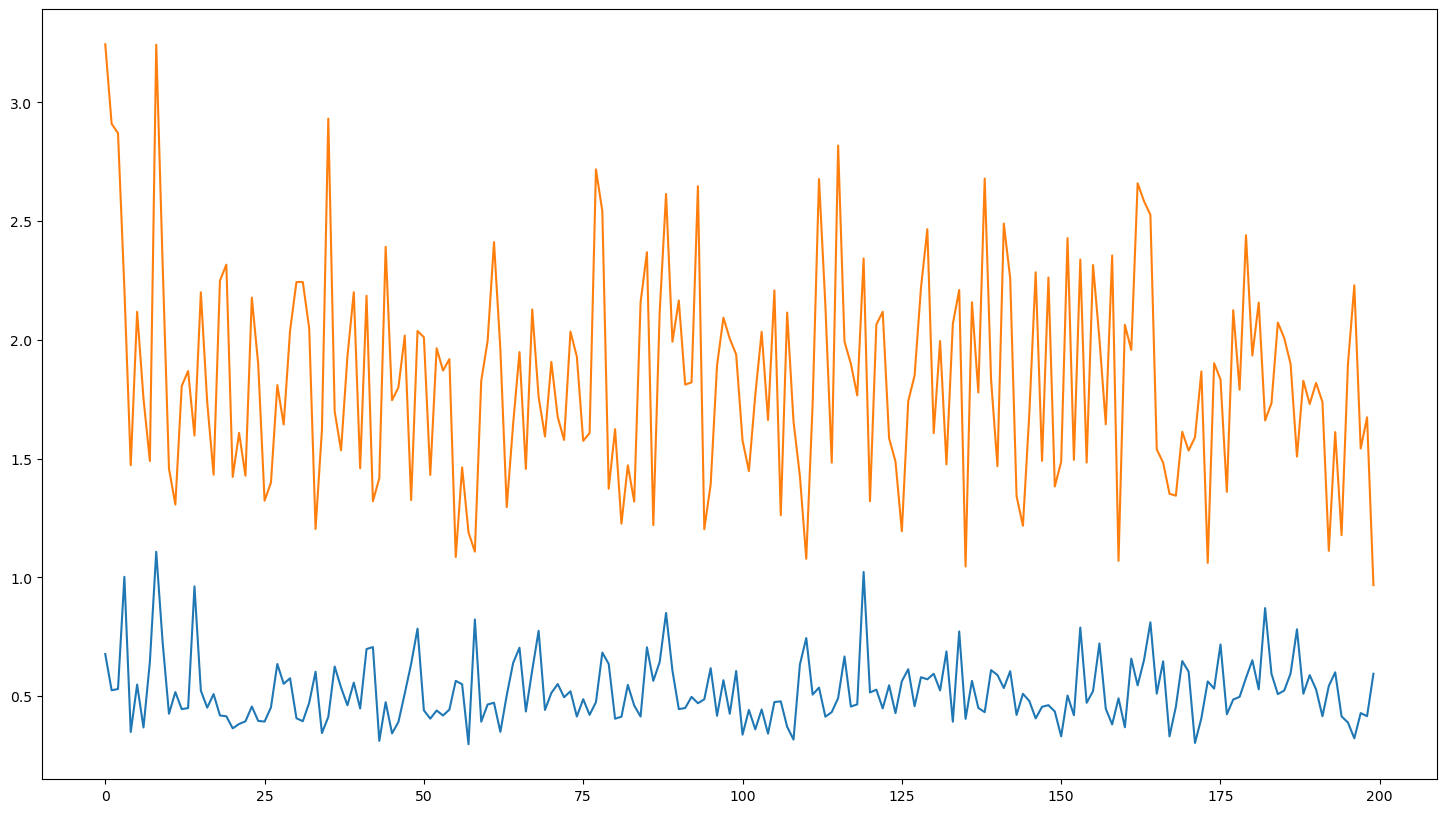

In [63]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_well_formed_ws_online_continue['Gen_D_KL']))
ax.plot(np.array(Analytic_well_formed_ws_online_continue['Data_D_KL']))
plt.show()

In [64]:
Analytic_well_formed_ws_online_continue.to_csv('Analytic_well_formed_ws_online_continue.csv', index = False)

In [65]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_well_formed_ws_online_continue',parameters)

### 2. Train with Mutual Information Maximization

In [82]:
para = np.load('Parameters_well_formed_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [81]:
Analytic_well_formed_ws_online_MI = pd.read_csv('Analytic_well_formed_ws_online.csv', sep=",")
Analytic_well_formed_ws_online_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.477162,0.608568,0.606603,0.592774,0.630917,0.464304,0.591105,0.588899,0.600768,3.244853,...,0.054938,7.077967,3.539952,3.953573,2.624095,1.505059,0.255339,0.148209,0.143978,0.127769
1,0.165550,0.222715,0.170283,0.215233,0.549830,0.226880,0.242490,0.176612,0.220423,2.910059,...,0.020334,7.210179,1.923169,1.440595,1.142938,0.672448,0.855700,0.114265,0.054400,0.053027
2,0.095268,0.078271,0.103717,0.138578,0.527883,0.206115,0.071097,0.097267,0.142885,2.870363,...,0.010310,7.329045,2.120772,0.915846,0.717171,0.519331,1.473279,0.062809,0.027192,0.027083
3,0.057512,0.032837,0.028669,0.034812,0.536871,0.151536,0.029915,0.022513,0.032624,2.216398,...,0.000990,6.681179,1.168330,0.185757,0.143927,0.112217,0.838982,0.003814,0.001400,0.004099
4,0.051279,0.022153,0.105351,0.014199,0.511674,0.181445,0.013579,0.104045,0.017790,1.471914,...,0.002230,7.224878,1.719337,0.074484,0.583950,0.064498,1.570638,0.002188,0.002704,0.002171
5,0.053084,0.091922,0.030859,0.033144,0.510217,0.173529,0.108264,0.039354,0.041337,2.118231,...,0.001530,7.036873,1.707897,0.726919,0.166233,0.105873,1.378877,0.057547,0.003458,0.002963
6,0.060100,0.017492,0.025061,0.019724,0.503924,0.195119,0.022809,0.025707,0.034752,1.752988,...,0.000307,7.299419,1.786663,0.237205,0.173930,0.070385,1.696158,0.011003,0.000872,0.001134
7,0.050100,0.006322,0.012269,0.035599,0.505968,0.182763,0.008357,0.014671,0.036716,1.489761,...,0.000513,6.876869,1.666472,0.067381,0.084214,0.079314,1.494292,0.002184,0.000326,0.001834
8,0.031755,0.007232,0.086452,0.025562,0.496759,0.175561,0.008249,0.079634,0.039151,3.242994,...,0.001882,6.648097,1.387494,0.054807,0.266315,0.089557,1.395724,0.002360,0.000537,0.003226
9,0.057800,0.008895,0.007203,0.036662,0.490554,0.200283,0.009381,0.008495,0.033395,2.323439,...,0.000241,7.001970,2.155481,0.046434,0.058112,0.096077,1.702484,0.002703,0.000166,0.001711


In [76]:
T,Epsilon,Eta = initialize_MI(data.repeat(1,10),Phi,lr,dev)
print('Epsilon: ',Epsilon)
print('Eta: ',Eta)
print('T: ',T)

Epsilon:  tensor([3.2605e-03, 7.1375e-05, 4.5755e-05, 7.4461e-03])
Eta:  tensor([3.2712e-03, 7.1380e-05, 4.5757e-05, 7.5020e-03])
T:  {'Layer1': tensor([1.1050e-04, 1.0000e+00, 7.4365e-02, 9.9613e-01, 9.9989e-01, 2.0552e-02,
        3.3149e-04, 9.9978e-01, 3.0586e-01, 6.8674e-01]), 'Layer2': tensor([1.1050e-04, 0.0000e+00, 1.1050e-04, 9.9956e-01, 9.9978e-01, 9.9989e-01,
        9.9989e-01, 2.2099e-04]), 'Layer3': tensor([9.9989e-01, 1.0000e+00, 3.3149e-04, 1.1050e-04, 9.9978e-01, 1.0000e+00]), 'Layer4': tensor([0.9466, 0.9999, 0.9989])}


In [97]:
batch_size = 1
lr = 0.1
epoch = 1000
gen_batch_size = 100000
n_data

905

In [98]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    T,Epsilon,Eta = initialize_MI(data.repeat(1,10),Phi,lr,dev)  # lr can be changed
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep, T = wake_phase_MI(Phi,Theta,data[:,index[i]:index[i]+1],lr,T,Epsilon,Eta,dev)
        else:
            Theta, Loss_sleep, T = wake_phase_update(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,T,Eta)
        # Sleep Phase
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
        values_g,counts_g = np.unique(decimalize_np(gen_data),return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=torch.from_numpy(counts_g).to(dev)/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_well_formed_ws_online_MI.loc[len(Analytic_well_formed_ws_online_MI)] = stat

Loss_wake: tensor([0.0000, 0.1390, 0.2234, 0.2759, 0.3532])     Loss_sleep: tensor([0.1905, 0.2832, 0.3515, 0.4584, 0.6813])
Loss_wake: tensor([0.0000, 0.1303, 0.2476, 0.2710, 0.3714])     Loss_sleep: tensor([0.1812, 0.2883, 0.3264, 0.4941, 0.6571])
Loss_wake: tensor([0.0000, 0.1184, 0.2256, 0.2711, 0.3726])     Loss_sleep: tensor([0.1789, 0.2861, 0.3279, 0.4960, 0.6707])
Loss_wake: tensor([0.0000, 0.1028, 0.2230, 0.3061, 0.3906])     Loss_sleep: tensor([0.1719, 0.2827, 0.3536, 0.4895, 0.6827])
Loss_wake: tensor([0.0000, 0.1030, 0.2327, 0.3223, 0.3724])     Loss_sleep: tensor([0.1664, 0.2902, 0.3614, 0.5011, 0.6534])
Loss_wake: tensor([0.0000, 0.1150, 0.2147, 0.3269, 0.3960])     Loss_sleep: tensor([0.1794, 0.2809, 0.3798, 0.5153, 0.6649])
Loss_wake: tensor([0.0000, 0.1111, 0.2274, 0.2989, 0.4069])     Loss_sleep: tensor([0.1639, 0.2844, 0.3476, 0.5061, 0.6731])
Loss_wake: tensor([0.0000, 0.1057, 0.2304, 0.2985, 0.3863])     Loss_sleep: tensor([0.1652, 0.2842, 0.3527, 0.5068, 0.6544])


Loss_wake: tensor([0.0000, 0.1194, 0.2502, 0.2888, 0.4068])     Loss_sleep: tensor([0.1754, 0.2991, 0.3411, 0.5154, 0.6825])
Loss_wake: tensor([0.0000, 0.1208, 0.2394, 0.2764, 0.3711])     Loss_sleep: tensor([0.1766, 0.3042, 0.3360, 0.4950, 0.6669])
Loss_wake: tensor([0.0000, 0.1085, 0.2548, 0.2646, 0.3671])     Loss_sleep: tensor([0.1751, 0.3141, 0.3310, 0.4628, 0.6777])
Loss_wake: tensor([0.0000, 0.1135, 0.2452, 0.2764, 0.3447])     Loss_sleep: tensor([0.1701, 0.2960, 0.3169, 0.5122, 0.6599])
Loss_wake: tensor([0.0000, 0.1059, 0.2484, 0.2884, 0.3746])     Loss_sleep: tensor([0.1724, 0.2815, 0.3239, 0.5130, 0.6690])
Loss_wake: tensor([0.0000, 0.1114, 0.2393, 0.3077, 0.3937])     Loss_sleep: tensor([0.1747, 0.2916, 0.3545, 0.4986, 0.6869])
Loss_wake: tensor([0.0000, 0.1140, 0.2352, 0.2692, 0.3754])     Loss_sleep: tensor([0.1807, 0.2867, 0.3330, 0.5160, 0.6491])
Loss_wake: tensor([0.0000, 0.1299, 0.2246, 0.2701, 0.3667])     Loss_sleep: tensor([0.1809, 0.2908, 0.3160, 0.4775, 0.6872])


Loss_wake: tensor([0.0000, 0.1136, 0.2698, 0.2947, 0.3811])     Loss_sleep: tensor([0.1680, 0.3099, 0.3561, 0.5178, 0.6497])
Loss_wake: tensor([0.0000, 0.1198, 0.2891, 0.3339, 0.3965])     Loss_sleep: tensor([0.1657, 0.3160, 0.3816, 0.5193, 0.6692])
Loss_wake: tensor([0.0000, 0.1276, 0.2722, 0.3053, 0.3685])     Loss_sleep: tensor([0.1661, 0.3252, 0.3562, 0.5096, 0.6622])
Loss_wake: tensor([0.0000, 0.1164, 0.2652, 0.2611, 0.3704])     Loss_sleep: tensor([0.1693, 0.3117, 0.3272, 0.4858, 0.6773])
Loss_wake: tensor([0.0000, 0.1236, 0.2404, 0.2424, 0.3663])     Loss_sleep: tensor([0.1713, 0.3120, 0.3253, 0.4842, 0.6611])
Loss_wake: tensor([0.0000, 0.1245, 0.2461, 0.2980, 0.3318])     Loss_sleep: tensor([0.1794, 0.3026, 0.3571, 0.4784, 0.6341])
Loss_wake: tensor([0.0000, 0.1314, 0.2717, 0.3063, 0.4047])     Loss_sleep: tensor([0.1763, 0.3155, 0.3583, 0.5102, 0.6718])
Loss_wake: tensor([0.0000, 0.1450, 0.2587, 0.3061, 0.3848])     Loss_sleep: tensor([0.1915, 0.3161, 0.3590, 0.4955, 0.6888])


Loss_wake: tensor([0.0000, 0.1291, 0.2535, 0.2648, 0.3911])     Loss_sleep: tensor([0.1893, 0.2950, 0.3422, 0.5093, 0.6720])
Loss_wake: tensor([0.0000, 0.1432, 0.2431, 0.2765, 0.3404])     Loss_sleep: tensor([0.1887, 0.2979, 0.3442, 0.4779, 0.6587])
Loss_wake: tensor([0.0000, 0.1296, 0.2272, 0.3230, 0.3647])     Loss_sleep: tensor([0.1793, 0.2917, 0.3834, 0.4815, 0.6693])
Loss_wake: tensor([0.0000, 0.1294, 0.2520, 0.3340, 0.3901])     Loss_sleep: tensor([0.1808, 0.2966, 0.3952, 0.4930, 0.6800])
Loss_wake: tensor([0.0000, 0.1261, 0.2555, 0.3221, 0.3830])     Loss_sleep: tensor([0.1820, 0.3104, 0.3576, 0.5351, 0.6363])
Loss_wake: tensor([0.0000, 0.1335, 0.2479, 0.2961, 0.4130])     Loss_sleep: tensor([0.1795, 0.3052, 0.3442, 0.5240, 0.6648])
Loss_wake: tensor([0.0000, 0.1072, 0.2496, 0.3069, 0.3749])     Loss_sleep: tensor([0.1613, 0.3064, 0.3694, 0.4861, 0.6793])
Loss_wake: tensor([0.0000, 0.1108, 0.2410, 0.2953, 0.3968])     Loss_sleep: tensor([0.1660, 0.3082, 0.3612, 0.4857, 0.6811])


Loss_wake: tensor([0.0000, 0.1006, 0.2830, 0.3310, 0.3941])     Loss_sleep: tensor([0.1713, 0.3147, 0.3888, 0.5101, 0.6563])
Loss_wake: tensor([0.0000, 0.1146, 0.3074, 0.3051, 0.3949])     Loss_sleep: tensor([0.1742, 0.3405, 0.3926, 0.4692, 0.6757])
Loss_wake: tensor([0.0000, 0.1083, 0.3172, 0.2665, 0.3940])     Loss_sleep: tensor([0.1675, 0.3534, 0.3864, 0.4582, 0.6733])
Loss_wake: tensor([0.0000, 0.0946, 0.3280, 0.3099, 0.3821])     Loss_sleep: tensor([0.1656, 0.3809, 0.3579, 0.4756, 0.6753])
Loss_wake: tensor([0.0000, 0.0929, 0.3180, 0.3417, 0.3570])     Loss_sleep: tensor([0.1629, 0.3557, 0.3756, 0.5088, 0.6447])
Loss_wake: tensor([0.0000, 0.1002, 0.3360, 0.3371, 0.3624])     Loss_sleep: tensor([0.1629, 0.3582, 0.3841, 0.5172, 0.6271])
Loss_wake: tensor([0.0000, 0.1124, 0.3113, 0.3213, 0.3144])     Loss_sleep: tensor([0.1643, 0.3539, 0.3912, 0.4962, 0.6065])
Loss_wake: tensor([0.0000, 0.1150, 0.3299, 0.3040, 0.3350])     Loss_sleep: tensor([0.1677, 0.3804, 0.3720, 0.4709, 0.6640])


Loss_wake: tensor([0.0000, 0.1232, 0.2906, 0.2918, 0.3273])     Loss_sleep: tensor([0.1737, 0.3393, 0.3509, 0.4712, 0.6678])
Loss_wake: tensor([0.0000, 0.1025, 0.2816, 0.2907, 0.3484])     Loss_sleep: tensor([0.1667, 0.3353, 0.3518, 0.4362, 0.6739])
Loss_wake: tensor([0.0000, 0.1228, 0.2725, 0.2629, 0.2851])     Loss_sleep: tensor([0.1775, 0.3475, 0.3245, 0.4519, 0.6068])
Loss_wake: tensor([0.0000, 0.1200, 0.2713, 0.2750, 0.2936])     Loss_sleep: tensor([0.1759, 0.3400, 0.3457, 0.4749, 0.5940])
Loss_wake: tensor([0.0000, 0.1152, 0.2748, 0.2857, 0.3189])     Loss_sleep: tensor([0.1753, 0.3417, 0.3328, 0.4733, 0.6417])
Loss_wake: tensor([0.0000, 0.1109, 0.2784, 0.2510, 0.3208])     Loss_sleep: tensor([0.1701, 0.3461, 0.3175, 0.4574, 0.6345])
Loss_wake: tensor([0.0000, 0.1148, 0.2975, 0.2484, 0.3322])     Loss_sleep: tensor([0.1745, 0.3374, 0.3265, 0.4608, 0.6642])
Loss_wake: tensor([0.0000, 0.0925, 0.3023, 0.2714, 0.3302])     Loss_sleep: tensor([0.1637, 0.3418, 0.3497, 0.4757, 0.6508])


Loss_wake: tensor([0.0000, 0.1059, 0.2722, 0.2919, 0.3933])     Loss_sleep: tensor([0.1643, 0.3270, 0.3519, 0.4779, 0.6861])
Loss_wake: tensor([0.0000, 0.1074, 0.2810, 0.3026, 0.4004])     Loss_sleep: tensor([0.1636, 0.3171, 0.3560, 0.5064, 0.6862])
Loss_wake: tensor([0.0000, 0.1180, 0.2792, 0.3030, 0.3869])     Loss_sleep: tensor([0.1802, 0.3234, 0.3703, 0.4950, 0.6828])
Loss_wake: tensor([0.0000, 0.0997, 0.2628, 0.3137, 0.3597])     Loss_sleep: tensor([0.1735, 0.3132, 0.3699, 0.4869, 0.6692])
Loss_wake: tensor([0.0000, 0.1133, 0.2754, 0.3216, 0.4078])     Loss_sleep: tensor([0.1717, 0.3190, 0.3683, 0.5030, 0.6790])
Loss_wake: tensor([0.0000, 0.1100, 0.2718, 0.2946, 0.3836])     Loss_sleep: tensor([0.1630, 0.3264, 0.3420, 0.4952, 0.6859])
Loss_wake: tensor([0.0000, 0.1240, 0.2959, 0.3260, 0.3919])     Loss_sleep: tensor([0.1732, 0.3411, 0.3571, 0.5321, 0.6598])
Loss_wake: tensor([0.0000, 0.1185, 0.2805, 0.3421, 0.3928])     Loss_sleep: tensor([0.1728, 0.3409, 0.3682, 0.5008, 0.6842])


Loss_wake: tensor([0.0000, 0.0896, 0.2654, 0.2216, 0.3561])     Loss_sleep: tensor([0.1584, 0.3301, 0.3114, 0.4750, 0.6762])
Loss_wake: tensor([0.0000, 0.0952, 0.2725, 0.2631, 0.3622])     Loss_sleep: tensor([0.1536, 0.3130, 0.3176, 0.5030, 0.6655])
Loss_wake: tensor([0.0000, 0.1015, 0.2650, 0.2931, 0.3782])     Loss_sleep: tensor([0.1604, 0.3086, 0.3375, 0.5143, 0.6878])
Loss_wake: tensor([0.0000, 0.0902, 0.2628, 0.2918, 0.3924])     Loss_sleep: tensor([0.1521, 0.3120, 0.3307, 0.5399, 0.6495])
Loss_wake: tensor([0.0000, 0.0910, 0.2462, 0.3032, 0.3903])     Loss_sleep: tensor([0.1537, 0.3064, 0.3388, 0.5521, 0.6298])
Loss_wake: tensor([0.0000, 0.0959, 0.2615, 0.2926, 0.3519])     Loss_sleep: tensor([0.1528, 0.3124, 0.3348, 0.4994, 0.6699])
Loss_wake: tensor([0.0000, 0.1060, 0.2477, 0.2485, 0.3336])     Loss_sleep: tensor([0.1616, 0.3163, 0.3097, 0.4804, 0.6503])
Loss_wake: tensor([0.0000, 0.0970, 0.2667, 0.2747, 0.3559])     Loss_sleep: tensor([0.1541, 0.3300, 0.3148, 0.4986, 0.6761])


Loss_wake: tensor([0.0000, 0.1004, 0.2997, 0.2718, 0.3138])     Loss_sleep: tensor([0.1628, 0.3447, 0.3401, 0.4712, 0.6757])
Loss_wake: tensor([0.0000, 0.0928, 0.2859, 0.2946, 0.3598])     Loss_sleep: tensor([0.1630, 0.3418, 0.3460, 0.4890, 0.6611])
Loss_wake: tensor([0.0000, 0.0932, 0.2948, 0.3146, 0.3975])     Loss_sleep: tensor([0.1534, 0.3457, 0.3668, 0.4934, 0.6951])
Loss_wake: tensor([0.0000, 0.1063, 0.3192, 0.2875, 0.3630])     Loss_sleep: tensor([0.1661, 0.3409, 0.3414, 0.5096, 0.6798])
Loss_wake: tensor([0.0000, 0.0924, 0.2911, 0.2995, 0.3784])     Loss_sleep: tensor([0.1581, 0.3353, 0.3515, 0.4995, 0.6830])
Loss_wake: tensor([0.0000, 0.1002, 0.2835, 0.2897, 0.4090])     Loss_sleep: tensor([0.1610, 0.3241, 0.3596, 0.5255, 0.6663])
Loss_wake: tensor([0.0000, 0.1158, 0.2975, 0.3119, 0.3887])     Loss_sleep: tensor([0.1734, 0.3313, 0.3680, 0.5054, 0.6787])
Loss_wake: tensor([0.0000, 0.1228, 0.3023, 0.2929, 0.3773])     Loss_sleep: tensor([0.1735, 0.3444, 0.3412, 0.5085, 0.6648])


Loss_wake: tensor([0.0000, 0.1327, 0.3016, 0.3270, 0.3979])     Loss_sleep: tensor([0.1747, 0.3447, 0.3775, 0.5180, 0.6628])
Loss_wake: tensor([0.0000, 0.1222, 0.2763, 0.2918, 0.3493])     Loss_sleep: tensor([0.1851, 0.3346, 0.3696, 0.4678, 0.6691])
Loss_wake: tensor([0.0000, 0.1363, 0.3028, 0.2936, 0.3905])     Loss_sleep: tensor([0.1859, 0.3322, 0.3661, 0.5196, 0.6663])
Loss_wake: tensor([0.0000, 0.1307, 0.2965, 0.2679, 0.3907])     Loss_sleep: tensor([0.1802, 0.3437, 0.3548, 0.4817, 0.6615])
Loss_wake: tensor([0.0000, 0.1391, 0.2897, 0.2952, 0.3381])     Loss_sleep: tensor([0.1823, 0.3320, 0.3739, 0.4564, 0.6658])
Loss_wake: tensor([0.0000, 0.1224, 0.2698, 0.2934, 0.3559])     Loss_sleep: tensor([0.1749, 0.3419, 0.3651, 0.4498, 0.6761])
Loss_wake: tensor([0.0000, 0.1293, 0.2773, 0.3110, 0.3627])     Loss_sleep: tensor([0.1730, 0.3303, 0.3769, 0.4949, 0.6769])
Loss_wake: tensor([0.0000, 0.1184, 0.2636, 0.2686, 0.3475])     Loss_sleep: tensor([0.1784, 0.3209, 0.3384, 0.4797, 0.6571])


Loss_wake: tensor([0.0000, 0.1199, 0.2808, 0.3123, 0.3471])     Loss_sleep: tensor([0.1781, 0.3156, 0.3738, 0.5069, 0.6163])
Loss_wake: tensor([0.0000, 0.1056, 0.2823, 0.3050, 0.3443])     Loss_sleep: tensor([0.1650, 0.3084, 0.3758, 0.4943, 0.6405])
Loss_wake: tensor([0.0000, 0.1102, 0.2717, 0.3316, 0.3371])     Loss_sleep: tensor([0.1657, 0.3163, 0.3744, 0.5253, 0.6016])
Loss_wake: tensor([0.0000, 0.1047, 0.2791, 0.2933, 0.3423])     Loss_sleep: tensor([0.1647, 0.3149, 0.3946, 0.4626, 0.6131])
Loss_wake: tensor([0.0000, 0.1072, 0.2803, 0.2866, 0.3566])     Loss_sleep: tensor([0.1676, 0.3170, 0.3823, 0.4764, 0.6386])
Loss_wake: tensor([0.0000, 0.1182, 0.2843, 0.3020, 0.3550])     Loss_sleep: tensor([0.1742, 0.3038, 0.3704, 0.5001, 0.6286])
Loss_wake: tensor([0.0000, 0.1067, 0.2860, 0.3240, 0.3605])     Loss_sleep: tensor([0.1749, 0.3131, 0.3949, 0.4966, 0.6597])
Loss_wake: tensor([0.0000, 0.1120, 0.3008, 0.2869, 0.3641])     Loss_sleep: tensor([0.1813, 0.3284, 0.3396, 0.4978, 0.6475])


Loss_wake: tensor([0.0000, 0.0989, 0.2887, 0.3580, 0.3642])     Loss_sleep: tensor([0.1662, 0.3125, 0.3928, 0.5567, 0.5843])
Loss_wake: tensor([0.0000, 0.1231, 0.2920, 0.3635, 0.3570])     Loss_sleep: tensor([0.1759, 0.3312, 0.3841, 0.5541, 0.5920])
Loss_wake: tensor([0.0000, 0.1107, 0.3007, 0.3570, 0.3743])     Loss_sleep: tensor([0.1764, 0.3403, 0.4001, 0.5250, 0.6238])
Loss_wake: tensor([0.0000, 0.1304, 0.3135, 0.3362, 0.3228])     Loss_sleep: tensor([0.1776, 0.3389, 0.3835, 0.5320, 0.5924])
Loss_wake: tensor([0.0000, 0.1089, 0.2997, 0.3276, 0.3704])     Loss_sleep: tensor([0.1797, 0.3416, 0.3782, 0.4889, 0.6547])
Loss_wake: tensor([0.0000, 0.1262, 0.2952, 0.3193, 0.4169])     Loss_sleep: tensor([0.1795, 0.3210, 0.3852, 0.5221, 0.6606])
Loss_wake: tensor([0.0000, 0.1282, 0.2860, 0.3211, 0.3821])     Loss_sleep: tensor([0.1861, 0.3424, 0.3693, 0.4923, 0.6533])
Loss_wake: tensor([0.0000, 0.1488, 0.3100, 0.2977, 0.3731])     Loss_sleep: tensor([0.1928, 0.3403, 0.3679, 0.5161, 0.6173])


Loss_wake: tensor([0.0000, 0.0939, 0.2902, 0.2927, 0.3694])     Loss_sleep: tensor([0.1473, 0.3425, 0.3858, 0.4414, 0.6928])
Loss_wake: tensor([0.0000, 0.0895, 0.2788, 0.2867, 0.3517])     Loss_sleep: tensor([0.1555, 0.3315, 0.3825, 0.4291, 0.6876])
Loss_wake: tensor([0.0000, 0.0851, 0.2570, 0.2967, 0.3495])     Loss_sleep: tensor([0.1548, 0.3103, 0.3938, 0.4350, 0.6730])
Loss_wake: tensor([0.0000, 0.0989, 0.2761, 0.3161, 0.3855])     Loss_sleep: tensor([0.1702, 0.3303, 0.3786, 0.4674, 0.6775])
Loss_wake: tensor([0.0000, 0.1023, 0.2714, 0.3311, 0.3357])     Loss_sleep: tensor([0.1753, 0.3340, 0.3742, 0.4634, 0.6706])
Loss_wake: tensor([0.0000, 0.1122, 0.2761, 0.2737, 0.2923])     Loss_sleep: tensor([0.1641, 0.3371, 0.3608, 0.4462, 0.6272])
Loss_wake: tensor([0.0000, 0.1000, 0.2601, 0.2715, 0.3087])     Loss_sleep: tensor([0.1605, 0.3131, 0.3433, 0.4561, 0.6350])
Loss_wake: tensor([0.0000, 0.0897, 0.2650, 0.2758, 0.3607])     Loss_sleep: tensor([0.1606, 0.3100, 0.3376, 0.4877, 0.6556])


Loss_wake: tensor([0.0000, 0.1124, 0.2826, 0.3252, 0.3927])     Loss_sleep: tensor([0.1867, 0.3196, 0.3656, 0.5079, 0.6555])
Loss_wake: tensor([0.0000, 0.1281, 0.2856, 0.3481, 0.3425])     Loss_sleep: tensor([0.1849, 0.3209, 0.3821, 0.5052, 0.6122])
Loss_wake: tensor([0.0000, 0.1122, 0.2798, 0.3298, 0.3825])     Loss_sleep: tensor([0.1878, 0.3238, 0.3905, 0.5142, 0.6094])
Loss_wake: tensor([0.0000, 0.1277, 0.2963, 0.3140, 0.3845])     Loss_sleep: tensor([0.1903, 0.3293, 0.3721, 0.4951, 0.6727])
Loss_wake: tensor([0.0000, 0.1166, 0.2906, 0.2802, 0.4052])     Loss_sleep: tensor([0.1733, 0.3351, 0.3482, 0.4959, 0.6746])
Loss_wake: tensor([0.0000, 0.1101, 0.2905, 0.2752, 0.3873])     Loss_sleep: tensor([0.1761, 0.3266, 0.3474, 0.4769, 0.6795])
Loss_wake: tensor([0.0000, 0.0916, 0.2999, 0.2631, 0.3906])     Loss_sleep: tensor([0.1677, 0.3223, 0.3374, 0.4992, 0.6748])
Loss_wake: tensor([0.0000, 0.0933, 0.3084, 0.2732, 0.3841])     Loss_sleep: tensor([0.1697, 0.3420, 0.3415, 0.4746, 0.6846])


Loss_wake: tensor([0.0000, 0.0829, 0.2525, 0.3413, 0.3219])     Loss_sleep: tensor([0.1480, 0.3044, 0.4145, 0.4746, 0.5892])
Loss_wake: tensor([0.0000, 0.0820, 0.2607, 0.3155, 0.3209])     Loss_sleep: tensor([0.1561, 0.2893, 0.3968, 0.4493, 0.6574])
Loss_wake: tensor([0.0000, 0.0795, 0.2639, 0.3031, 0.3391])     Loss_sleep: tensor([0.1553, 0.3013, 0.4095, 0.4438, 0.6402])
Loss_wake: tensor([0.0000, 0.0889, 0.2766, 0.2979, 0.3274])     Loss_sleep: tensor([0.1560, 0.3109, 0.3930, 0.4503, 0.6626])
Loss_wake: tensor([0.0000, 0.0894, 0.2928, 0.3297, 0.3448])     Loss_sleep: tensor([0.1520, 0.3267, 0.3886, 0.4670, 0.6766])
Loss_wake: tensor([0.0000, 0.0969, 0.2564, 0.3149, 0.3336])     Loss_sleep: tensor([0.1646, 0.3150, 0.4001, 0.4433, 0.6531])
Loss_wake: tensor([0.0000, 0.1026, 0.2528, 0.2992, 0.3436])     Loss_sleep: tensor([0.1677, 0.3043, 0.3822, 0.4394, 0.6508])
Loss_wake: tensor([0.0000, 0.0905, 0.2596, 0.3027, 0.3696])     Loss_sleep: tensor([0.1590, 0.3070, 0.4036, 0.4436, 0.6732])


Loss_wake: tensor([0.0000, 0.0799, 0.2760, 0.2661, 0.3132])     Loss_sleep: tensor([0.1543, 0.3417, 0.3194, 0.4719, 0.6396])
Loss_wake: tensor([0.0000, 0.0905, 0.2961, 0.2735, 0.3429])     Loss_sleep: tensor([0.1515, 0.3358, 0.3289, 0.4936, 0.6526])
Loss_wake: tensor([0.0000, 0.1009, 0.2740, 0.2742, 0.3404])     Loss_sleep: tensor([0.1560, 0.3209, 0.3390, 0.4999, 0.6456])
Loss_wake: tensor([0.0000, 0.0842, 0.2703, 0.3069, 0.3274])     Loss_sleep: tensor([0.1496, 0.3457, 0.3494, 0.4994, 0.6282])
Loss_wake: tensor([0.0000, 0.0807, 0.2870, 0.2599, 0.3091])     Loss_sleep: tensor([0.1486, 0.3228, 0.3410, 0.4578, 0.6282])
Loss_wake: tensor([0.0000, 0.0963, 0.2638, 0.2443, 0.3257])     Loss_sleep: tensor([0.1652, 0.3200, 0.3228, 0.4564, 0.6740])
Loss_wake: tensor([0.0000, 0.0813, 0.2672, 0.2718, 0.3272])     Loss_sleep: tensor([0.1511, 0.3087, 0.3402, 0.4574, 0.6711])
Loss_wake: tensor([0.0000, 0.0835, 0.2493, 0.2686, 0.3464])     Loss_sleep: tensor([0.1542, 0.3017, 0.3292, 0.4976, 0.6273])


In [99]:
Analytic_well_formed_ws_online_MI

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.477162,0.608568,0.606603,0.592774,0.630917,0.464304,0.591105,0.588899,0.600768,3.244853,...,0.054938,7.077967,3.539952,3.953573,2.624095,1.505059,0.255339,0.148209,0.143978,0.127769
1,0.165550,0.222715,0.170283,0.215233,0.549830,0.226880,0.242490,0.176612,0.220423,2.910059,...,0.020334,7.210179,1.923169,1.440595,1.142938,0.672448,0.855700,0.114265,0.054400,0.053027
2,0.095268,0.078271,0.103717,0.138578,0.527883,0.206115,0.071097,0.097267,0.142885,2.870363,...,0.010310,7.329045,2.120772,0.915846,0.717171,0.519331,1.473279,0.062809,0.027192,0.027083
3,0.057512,0.032837,0.028669,0.034812,0.536871,0.151536,0.029915,0.022513,0.032624,2.216398,...,0.000990,6.681179,1.168330,0.185757,0.143927,0.112217,0.838982,0.003814,0.001400,0.004099
4,0.051279,0.022153,0.105351,0.014199,0.511674,0.181445,0.013579,0.104045,0.017790,1.471914,...,0.002230,7.224878,1.719337,0.074484,0.583950,0.064498,1.570638,0.002188,0.002704,0.002171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.086270,0.241061,0.327827,0.343310,0.158439,0.313772,0.355303,0.481953,0.652070,1.136442,...,0.872531,7.260147,6.376884,4.945453,3.961855,1.929812,5.525666,3.208674,2.166694,1.007673
196,0.085767,0.271389,0.290644,0.375210,0.166302,0.310481,0.371322,0.472718,0.687647,1.316187,...,0.988825,7.211313,6.272719,5.322787,3.761147,1.940751,5.433384,3.286021,2.455644,0.985551
197,0.128027,0.307638,0.299699,0.398950,0.183237,0.344009,0.362350,0.500182,0.676328,0.887566,...,0.895480,7.202060,6.486202,5.304519,3.944118,2.054367,5.177270,2.995947,2.541026,0.997512
198,0.112787,0.304445,0.269824,0.373530,0.163262,0.346882,0.346211,0.470063,0.686186,0.994725,...,0.914586,7.263698,6.397587,5.163453,3.886322,2.000359,5.376385,3.096875,2.446673,1.003324


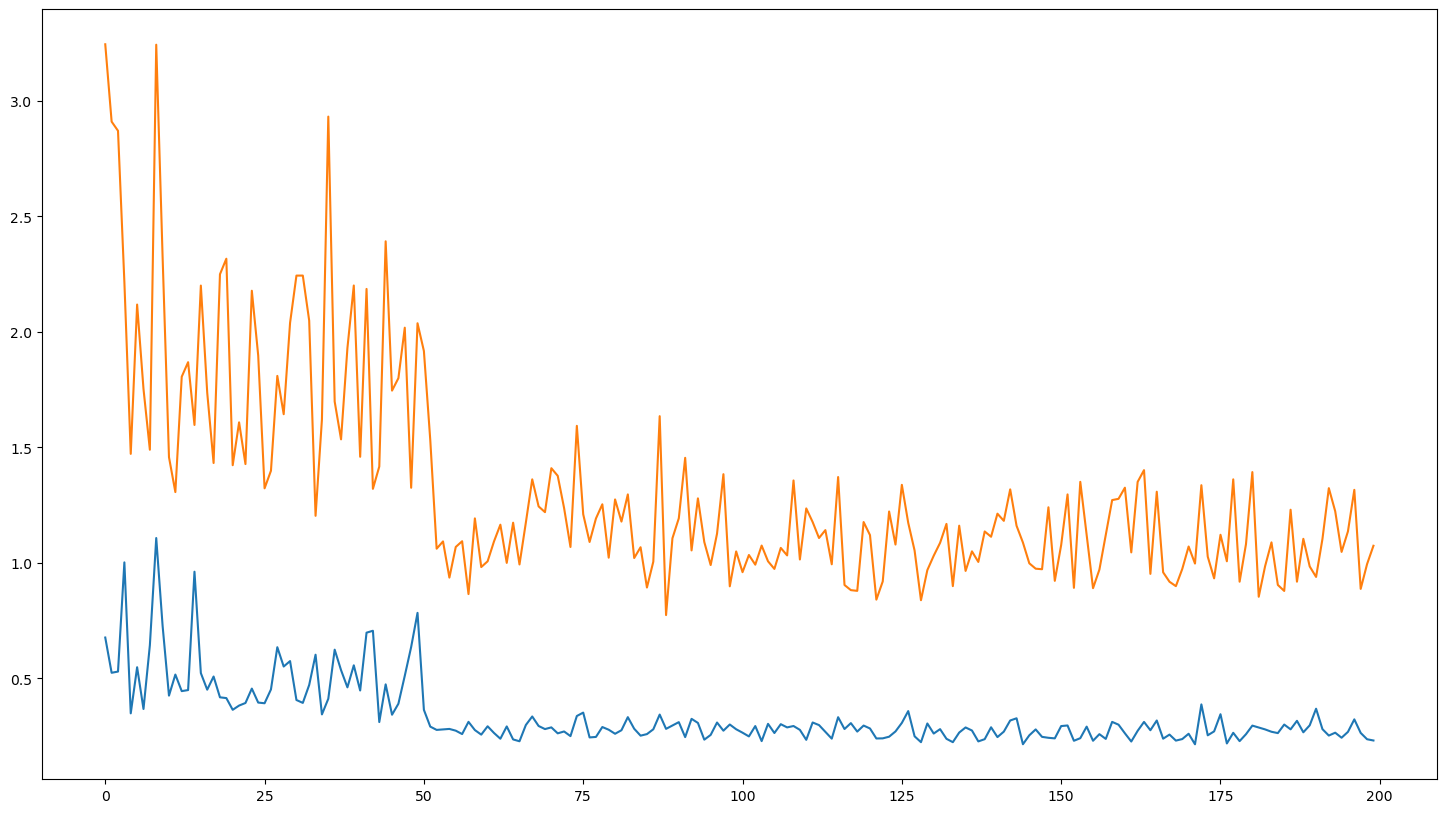

In [100]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_well_formed_ws_online_MI['Gen_D_KL']))
ax.plot(np.array(Analytic_well_formed_ws_online_MI['Data_D_KL']))
plt.show()

In [101]:
Analytic_well_formed_ws_online_MI.to_csv('Analytic_well_formed_ws_online_MI.csv', index = False)

In [102]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_well_formed_ws_online_MI',parameters)

### 3. Train with Perturbation

In [111]:
para = np.load('Parameters_well_formed_ws_online.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [112]:
Analytic_well_formed_ws_online_perturb = pd.read_csv('Analytic_well_formed_ws_online.csv', sep=",")
Analytic_well_formed_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.477162,0.608568,0.606603,0.592774,0.630917,0.464304,0.591105,0.588899,0.600768,3.244853,...,0.054938,7.077967,3.539952,3.953573,2.624095,1.505059,0.255339,0.148209,0.143978,0.127769
1,0.165550,0.222715,0.170283,0.215233,0.549830,0.226880,0.242490,0.176612,0.220423,2.910059,...,0.020334,7.210179,1.923169,1.440595,1.142938,0.672448,0.855700,0.114265,0.054400,0.053027
2,0.095268,0.078271,0.103717,0.138578,0.527883,0.206115,0.071097,0.097267,0.142885,2.870363,...,0.010310,7.329045,2.120772,0.915846,0.717171,0.519331,1.473279,0.062809,0.027192,0.027083
3,0.057512,0.032837,0.028669,0.034812,0.536871,0.151536,0.029915,0.022513,0.032624,2.216398,...,0.000990,6.681179,1.168330,0.185757,0.143927,0.112217,0.838982,0.003814,0.001400,0.004099
4,0.051279,0.022153,0.105351,0.014199,0.511674,0.181445,0.013579,0.104045,0.017790,1.471914,...,0.002230,7.224878,1.719337,0.074484,0.583950,0.064498,1.570638,0.002188,0.002704,0.002171
5,0.053084,0.091922,0.030859,0.033144,0.510217,0.173529,0.108264,0.039354,0.041337,2.118231,...,0.001530,7.036873,1.707897,0.726919,0.166233,0.105873,1.378877,0.057547,0.003458,0.002963
6,0.060100,0.017492,0.025061,0.019724,0.503924,0.195119,0.022809,0.025707,0.034752,1.752988,...,0.000307,7.299419,1.786663,0.237205,0.173930,0.070385,1.696158,0.011003,0.000872,0.001134
7,0.050100,0.006322,0.012269,0.035599,0.505968,0.182763,0.008357,0.014671,0.036716,1.489761,...,0.000513,6.876869,1.666472,0.067381,0.084214,0.079314,1.494292,0.002184,0.000326,0.001834
8,0.031755,0.007232,0.086452,0.025562,0.496759,0.175561,0.008249,0.079634,0.039151,3.242994,...,0.001882,6.648097,1.387494,0.054807,0.266315,0.089557,1.395724,0.002360,0.000537,0.003226
9,0.057800,0.008895,0.007203,0.036662,0.490554,0.200283,0.009381,0.008495,0.033395,2.323439,...,0.000241,7.001970,2.155481,0.046434,0.058112,0.096077,1.702484,0.002703,0.000166,0.001711


In [113]:
batch_size = 1
lr = 0.1
epoch = 1500
gen_batch_size = 100000
n_data

905

In [114]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(n_data):
        if i%10 == 0:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=True)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev,perturb=False)
            
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e%10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        
        gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
        values_g,counts_g = np.unique(decimalize_np(gen_data),return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=torch.from_numpy(counts_g).to(dev)/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.numpy()) + list(I_wake.numpy()) + list(H_Y_sleep.numpy()) + list(I_sleep.numpy())
        Analytic_well_formed_ws_online_perturb.loc[len(Analytic_well_formed_ws_online_perturb)] = stat

Loss_wake: tensor([0.0000, 0.0494, 0.0393, 0.0124, 0.1918])     Loss_sleep: tensor([0.5680, 0.2632, 0.1359, 0.1286, 0.3241])
Loss_wake: tensor([0.0000, 0.1430, 0.1505, 0.1507, 0.2524])     Loss_sleep: tensor([0.5285, 0.3191, 0.1642, 0.1573, 0.3198])
Loss_wake: tensor([0.0000, 0.2826, 0.2803, 0.3290, 0.3673])     Loss_sleep: tensor([0.5177, 0.4230, 0.3102, 0.3646, 0.3988])
Loss_wake: tensor([0.0000, 0.3587, 0.4505, 0.5253, 0.4991])     Loss_sleep: tensor([0.4822, 0.4925, 0.4766, 0.5534, 0.5450])
Loss_wake: tensor([0.0000, 0.3630, 0.5056, 0.5585, 0.5566])     Loss_sleep: tensor([0.4939, 0.4898, 0.5278, 0.5894, 0.6041])
Loss_wake: tensor([0.0000, 0.3885, 0.5412, 0.5918, 0.5256])     Loss_sleep: tensor([0.4908, 0.4961, 0.5657, 0.6242, 0.5520])
Loss_wake: tensor([0.0000, 0.4135, 0.5023, 0.5961, 0.6050])     Loss_sleep: tensor([0.4650, 0.5587, 0.5384, 0.6197, 0.6261])
Loss_wake: tensor([0.0000, 0.4463, 0.5674, 0.5975, 0.6157])     Loss_sleep: tensor([0.4618, 0.5705, 0.5813, 0.6383, 0.6530])


Loss_wake: tensor([0.0000, 0.5329, 0.5871, 0.5859, 0.6564])     Loss_sleep: tensor([0.5126, 0.5932, 0.5819, 0.6608, 0.6777])
Loss_wake: tensor([0.0000, 0.4976, 0.5762, 0.5999, 0.6474])     Loss_sleep: tensor([0.5296, 0.5461, 0.5849, 0.6664, 0.6662])
Loss_wake: tensor([0.0000, 0.5174, 0.5827, 0.5970, 0.5893])     Loss_sleep: tensor([0.5298, 0.5633, 0.5963, 0.6510, 0.6301])
Loss_wake: tensor([0.0000, 0.5292, 0.5669, 0.6138, 0.5219])     Loss_sleep: tensor([0.5214, 0.5973, 0.5744, 0.6573, 0.5388])
Loss_wake: tensor([0.0000, 0.5192, 0.5945, 0.6364, 0.6126])     Loss_sleep: tensor([0.5216, 0.5801, 0.6105, 0.6580, 0.6410])
Loss_wake: tensor([0.0000, 0.4975, 0.5759, 0.6080, 0.6046])     Loss_sleep: tensor([0.5033, 0.5757, 0.5927, 0.6485, 0.6441])
Loss_wake: tensor([0.0000, 0.4253, 0.5982, 0.6309, 0.6107])     Loss_sleep: tensor([0.5207, 0.4942, 0.6105, 0.6569, 0.6444])
Loss_wake: tensor([0.0000, 0.4870, 0.5834, 0.6184, 0.6187])     Loss_sleep: tensor([0.5163, 0.5458, 0.6202, 0.6389, 0.6623])


Loss_wake: tensor([0.0000, 0.5347, 0.5399, 0.5872, 0.5665])     Loss_sleep: tensor([0.5108, 0.5894, 0.5901, 0.5948, 0.6392])
Loss_wake: tensor([0.0000, 0.4931, 0.5501, 0.5746, 0.6057])     Loss_sleep: tensor([0.5127, 0.5651, 0.5954, 0.5833, 0.6559])
Loss_wake: tensor([0.0000, 0.5115, 0.5833, 0.5836, 0.5990])     Loss_sleep: tensor([0.5080, 0.5818, 0.6177, 0.5935, 0.6506])
Loss_wake: tensor([0.0000, 0.5127, 0.5896, 0.5757, 0.6312])     Loss_sleep: tensor([0.5065, 0.5833, 0.6261, 0.6043, 0.6680])
Loss_wake: tensor([0.0000, 0.4757, 0.4948, 0.5833, 0.5872])     Loss_sleep: tensor([0.5046, 0.5724, 0.5284, 0.6057, 0.6313])
Loss_wake: tensor([0.0000, 0.4733, 0.5457, 0.5512, 0.5558])     Loss_sleep: tensor([0.5083, 0.5589, 0.5789, 0.5794, 0.5949])
Loss_wake: tensor([0.0000, 0.4571, 0.5189, 0.4787, 0.4900])     Loss_sleep: tensor([0.5174, 0.5553, 0.5438, 0.4998, 0.5381])
Loss_wake: tensor([0.0000, 0.4641, 0.5223, 0.5079, 0.4838])     Loss_sleep: tensor([0.5207, 0.5527, 0.5464, 0.5273, 0.5446])


Loss_wake: tensor([0.0000, 0.4933, 0.5904, 0.5926, 0.5715])     Loss_sleep: tensor([0.5112, 0.5724, 0.6124, 0.5976, 0.6343])
Loss_wake: tensor([0.0000, 0.5084, 0.6024, 0.5963, 0.5916])     Loss_sleep: tensor([0.5155, 0.5707, 0.6294, 0.6065, 0.6717])
Loss_wake: tensor([0.0000, 0.5210, 0.5600, 0.6361, 0.5816])     Loss_sleep: tensor([0.5040, 0.6120, 0.5685, 0.6481, 0.6454])
Loss_wake: tensor([0.0000, 0.5036, 0.5675, 0.6029, 0.5065])     Loss_sleep: tensor([0.5104, 0.5681, 0.6132, 0.6180, 0.5675])
Loss_wake: tensor([0.0000, 0.5216, 0.5491, 0.6044, 0.5425])     Loss_sleep: tensor([0.5045, 0.5950, 0.5957, 0.6230, 0.6020])
Loss_wake: tensor([0.0000, 0.4838, 0.5692, 0.6332, 0.5700])     Loss_sleep: tensor([0.5084, 0.5363, 0.6054, 0.6515, 0.6168])
Loss_wake: tensor([0.0000, 0.4958, 0.5742, 0.6246, 0.5270])     Loss_sleep: tensor([0.5164, 0.5528, 0.6265, 0.6445, 0.5736])
Loss_wake: tensor([0.0000, 0.4923, 0.5687, 0.5965, 0.5773])     Loss_sleep: tensor([0.5120, 0.5523, 0.6075, 0.6212, 0.6303])


Loss_wake: tensor([0.0000, 0.5453, 0.5571, 0.6101, 0.5930])     Loss_sleep: tensor([0.5121, 0.6051, 0.5947, 0.6298, 0.6391])
Loss_wake: tensor([0.0000, 0.5246, 0.5593, 0.5816, 0.5744])     Loss_sleep: tensor([0.5130, 0.5778, 0.5910, 0.6107, 0.6284])
Loss_wake: tensor([0.0000, 0.4509, 0.5189, 0.5429, 0.5059])     Loss_sleep: tensor([0.5299, 0.5251, 0.5516, 0.5522, 0.5671])
Loss_wake: tensor([0.0000, 0.4540, 0.4999, 0.5317, 0.5133])     Loss_sleep: tensor([0.5385, 0.5138, 0.5402, 0.5341, 0.5922])
Loss_wake: tensor([0.0000, 0.4971, 0.5919, 0.6069, 0.5382])     Loss_sleep: tensor([0.5242, 0.5507, 0.6213, 0.6294, 0.6034])
Loss_wake: tensor([0.0000, 0.5217, 0.5425, 0.5925, 0.5622])     Loss_sleep: tensor([0.5324, 0.5603, 0.5792, 0.6189, 0.6210])
Loss_wake: tensor([0.0000, 0.4990, 0.5314, 0.5772, 0.5799])     Loss_sleep: tensor([0.5228, 0.5568, 0.5775, 0.5946, 0.6489])
Loss_wake: tensor([0.0000, 0.5068, 0.5679, 0.5870, 0.5724])     Loss_sleep: tensor([0.5177, 0.5594, 0.5889, 0.6021, 0.6586])


Loss_wake: tensor([0.0000, 0.4763, 0.5472, 0.5897, 0.6337])     Loss_sleep: tensor([0.5239, 0.5378, 0.5900, 0.6134, 0.6691])
Loss_wake: tensor([0.0000, 0.5010, 0.5828, 0.5655, 0.6355])     Loss_sleep: tensor([0.5192, 0.5543, 0.6134, 0.6059, 0.6829])
Loss_wake: tensor([0.0000, 0.5275, 0.5696, 0.5614, 0.5357])     Loss_sleep: tensor([0.5258, 0.5666, 0.6126, 0.6008, 0.6123])
Loss_wake: tensor([0.0000, 0.4792, 0.5771, 0.6076, 0.5693])     Loss_sleep: tensor([0.5294, 0.5342, 0.5903, 0.6411, 0.6038])
Loss_wake: tensor([0.0000, 0.5197, 0.5675, 0.6178, 0.5804])     Loss_sleep: tensor([0.5360, 0.5512, 0.6044, 0.6521, 0.6193])
Loss_wake: tensor([0.0000, 0.5127, 0.5454, 0.6072, 0.5676])     Loss_sleep: tensor([0.5397, 0.5557, 0.5652, 0.6314, 0.6317])
Loss_wake: tensor([0.0000, 0.5324, 0.5418, 0.6015, 0.6087])     Loss_sleep: tensor([0.5272, 0.5875, 0.5596, 0.6368, 0.6589])
Loss_wake: tensor([0.0000, 0.5256, 0.5714, 0.5919, 0.5958])     Loss_sleep: tensor([0.5186, 0.5837, 0.5859, 0.6273, 0.6600])


Loss_wake: tensor([0.0000, 0.5211, 0.5821, 0.5100, 0.5556])     Loss_sleep: tensor([0.5208, 0.5811, 0.6104, 0.5480, 0.6131])
Loss_wake: tensor([0.0000, 0.5123, 0.5883, 0.5544, 0.5831])     Loss_sleep: tensor([0.5298, 0.5683, 0.6171, 0.5853, 0.6414])
Loss_wake: tensor([0.0000, 0.5156, 0.5870, 0.6234, 0.5956])     Loss_sleep: tensor([0.5177, 0.5780, 0.5964, 0.6436, 0.6604])
Loss_wake: tensor([0.0000, 0.4872, 0.5776, 0.6167, 0.5643])     Loss_sleep: tensor([0.5047, 0.5846, 0.6015, 0.6401, 0.6274])
Loss_wake: tensor([0.0000, 0.4926, 0.5491, 0.5894, 0.5926])     Loss_sleep: tensor([0.5134, 0.5751, 0.5818, 0.6228, 0.6379])
Loss_wake: tensor([0.0000, 0.5237, 0.5785, 0.6021, 0.6166])     Loss_sleep: tensor([0.5028, 0.5964, 0.6168, 0.6232, 0.6573])
Loss_wake: tensor([0.0000, 0.5027, 0.5761, 0.6341, 0.6029])     Loss_sleep: tensor([0.5005, 0.5830, 0.6131, 0.6491, 0.6683])
Loss_wake: tensor([0.0000, 0.4620, 0.5653, 0.5873, 0.5737])     Loss_sleep: tensor([0.5183, 0.5428, 0.5885, 0.6018, 0.6652])


Loss_wake: tensor([0.0000, 0.4957, 0.5899, 0.6121, 0.6103])     Loss_sleep: tensor([0.5166, 0.5566, 0.6186, 0.6262, 0.6682])
Loss_wake: tensor([0.0000, 0.5109, 0.5675, 0.6270, 0.5552])     Loss_sleep: tensor([0.5258, 0.5636, 0.6018, 0.6420, 0.6219])
Loss_wake: tensor([0.0000, 0.5121, 0.5771, 0.5785, 0.5973])     Loss_sleep: tensor([0.5044, 0.5802, 0.6043, 0.5813, 0.6633])
Loss_wake: tensor([0.0000, 0.5150, 0.5843, 0.6080, 0.6190])     Loss_sleep: tensor([0.5137, 0.5864, 0.6036, 0.6229, 0.6749])
Loss_wake: tensor([0.0000, 0.4967, 0.6001, 0.6330, 0.5715])     Loss_sleep: tensor([0.5141, 0.5593, 0.6217, 0.6433, 0.6358])
Loss_wake: tensor([0.0000, 0.4905, 0.5628, 0.6012, 0.5777])     Loss_sleep: tensor([0.5126, 0.5720, 0.6067, 0.6213, 0.6360])
Loss_wake: tensor([0.0000, 0.5194, 0.5859, 0.5775, 0.6023])     Loss_sleep: tensor([0.5084, 0.5944, 0.6219, 0.5953, 0.6396])
Loss_wake: tensor([0.0000, 0.5182, 0.5777, 0.5942, 0.6241])     Loss_sleep: tensor([0.5108, 0.5830, 0.6042, 0.6225, 0.6580])


Loss_wake: tensor([0.0000, 0.4772, 0.5627, 0.6069, 0.5636])     Loss_sleep: tensor([0.5080, 0.5649, 0.5845, 0.6480, 0.5871])
Loss_wake: tensor([0.0000, 0.4651, 0.5906, 0.6105, 0.5703])     Loss_sleep: tensor([0.4921, 0.5506, 0.6150, 0.6410, 0.6112])
Loss_wake: tensor([0.0000, 0.5119, 0.5900, 0.6375, 0.6088])     Loss_sleep: tensor([0.4984, 0.5913, 0.6165, 0.6613, 0.6539])
Loss_wake: tensor([0.0000, 0.4738, 0.5578, 0.5934, 0.6204])     Loss_sleep: tensor([0.5132, 0.5551, 0.5556, 0.6619, 0.6671])
Loss_wake: tensor([0.0000, 0.4689, 0.5740, 0.5898, 0.6356])     Loss_sleep: tensor([0.5160, 0.5456, 0.5607, 0.6518, 0.6714])
Loss_wake: tensor([0.0000, 0.4812, 0.5208, 0.5703, 0.5340])     Loss_sleep: tensor([0.5075, 0.5685, 0.5334, 0.6222, 0.5810])
Loss_wake: tensor([0.0000, 0.5183, 0.5241, 0.5301, 0.5404])     Loss_sleep: tensor([0.5088, 0.5844, 0.5386, 0.5852, 0.5969])
Loss_wake: tensor([0.0000, 0.5252, 0.5783, 0.6123, 0.6017])     Loss_sleep: tensor([0.5148, 0.5842, 0.6012, 0.6403, 0.6636])


Loss_wake: tensor([0.0000, 0.5111, 0.5665, 0.6340, 0.5693])     Loss_sleep: tensor([0.4939, 0.5851, 0.6035, 0.6481, 0.6422])
Loss_wake: tensor([0.0000, 0.4830, 0.5811, 0.6092, 0.5584])     Loss_sleep: tensor([0.5255, 0.5482, 0.6149, 0.6264, 0.6065])
Loss_wake: tensor([0.0000, 0.4865, 0.5596, 0.6152, 0.6210])     Loss_sleep: tensor([0.5067, 0.5591, 0.6024, 0.6417, 0.6667])
Loss_wake: tensor([0.0000, 0.5217, 0.5861, 0.5956, 0.5786])     Loss_sleep: tensor([0.5048, 0.5771, 0.6297, 0.6218, 0.6311])
Loss_wake: tensor([0.0000, 0.5064, 0.5774, 0.6192, 0.5000])     Loss_sleep: tensor([0.5138, 0.5560, 0.6170, 0.6447, 0.5609])
Loss_wake: tensor([0.0000, 0.5265, 0.5786, 0.6321, 0.5358])     Loss_sleep: tensor([0.5085, 0.5975, 0.6107, 0.6637, 0.5775])
Loss_wake: tensor([0.0000, 0.5151, 0.5805, 0.6441, 0.6087])     Loss_sleep: tensor([0.5046, 0.5807, 0.6175, 0.6660, 0.6676])
Loss_wake: tensor([0.0000, 0.4858, 0.5919, 0.6146, 0.5904])     Loss_sleep: tensor([0.5253, 0.5584, 0.6099, 0.6392, 0.6281])


Loss_wake: tensor([0.0000, 0.4913, 0.5332, 0.5982, 0.5977])     Loss_sleep: tensor([0.5128, 0.5728, 0.5660, 0.6254, 0.6652])
Loss_wake: tensor([0.0000, 0.5190, 0.5576, 0.6300, 0.6327])     Loss_sleep: tensor([0.5121, 0.5746, 0.5922, 0.6641, 0.6612])
Loss_wake: tensor([0.0000, 0.5053, 0.5793, 0.6005, 0.6593])     Loss_sleep: tensor([0.5167, 0.5634, 0.6015, 0.6386, 0.6930])
Loss_wake: tensor([0.0000, 0.4969, 0.5944, 0.5934, 0.6281])     Loss_sleep: tensor([0.5187, 0.5644, 0.6156, 0.6153, 0.6813])
Loss_wake: tensor([0.0000, 0.4961, 0.5611, 0.5219, 0.5701])     Loss_sleep: tensor([0.5158, 0.5654, 0.5839, 0.5396, 0.6549])
Loss_wake: tensor([0.0000, 0.5156, 0.5495, 0.5373, 0.5763])     Loss_sleep: tensor([0.5252, 0.5729, 0.5608, 0.5588, 0.6619])
Loss_wake: tensor([0.0000, 0.4995, 0.5480, 0.6084, 0.5722])     Loss_sleep: tensor([0.5301, 0.5633, 0.5539, 0.6289, 0.6249])
Loss_wake: tensor([0.0000, 0.5169, 0.5665, 0.6028, 0.5804])     Loss_sleep: tensor([0.5225, 0.5762, 0.6023, 0.6189, 0.6432])


Loss_wake: tensor([0.0000, 0.4481, 0.5242, 0.5523, 0.4772])     Loss_sleep: tensor([0.5220, 0.5207, 0.5598, 0.6057, 0.4955])
Loss_wake: tensor([0.0000, 0.4545, 0.5490, 0.5542, 0.5733])     Loss_sleep: tensor([0.5293, 0.5357, 0.5656, 0.5885, 0.6072])
Loss_wake: tensor([0.0000, 0.4893, 0.4777, 0.5626, 0.5368])     Loss_sleep: tensor([0.5253, 0.5587, 0.4933, 0.5889, 0.5774])
Loss_wake: tensor([0.0000, 0.5012, 0.5238, 0.5565, 0.5274])     Loss_sleep: tensor([0.5269, 0.5520, 0.5623, 0.5846, 0.5445])
Loss_wake: tensor([0.0000, 0.5036, 0.5705, 0.5807, 0.6048])     Loss_sleep: tensor([0.5267, 0.5575, 0.6054, 0.6281, 0.6346])
Loss_wake: tensor([0.0000, 0.5032, 0.5811, 0.5743, 0.5944])     Loss_sleep: tensor([0.5189, 0.5643, 0.6113, 0.6123, 0.6497])
Loss_wake: tensor([0.0000, 0.5230, 0.5632, 0.5920, 0.5996])     Loss_sleep: tensor([0.5120, 0.5727, 0.5971, 0.6208, 0.6556])
Loss_wake: tensor([0.0000, 0.5407, 0.5814, 0.5858, 0.5863])     Loss_sleep: tensor([0.5128, 0.5977, 0.5960, 0.6150, 0.6593])


Loss_wake: tensor([0.0000, 0.5222, 0.5620, 0.6297, 0.5363])     Loss_sleep: tensor([0.5068, 0.5751, 0.6093, 0.6666, 0.5753])
Loss_wake: tensor([0.0000, 0.4882, 0.5831, 0.5946, 0.5251])     Loss_sleep: tensor([0.5230, 0.5387, 0.5939, 0.6457, 0.5763])
Loss_wake: tensor([0.0000, 0.4907, 0.5315, 0.6155, 0.5636])     Loss_sleep: tensor([0.5242, 0.5461, 0.5643, 0.6475, 0.6127])
Loss_wake: tensor([0.0000, 0.4952, 0.5622, 0.5633, 0.5828])     Loss_sleep: tensor([0.5276, 0.5465, 0.5752, 0.6185, 0.6185])
Loss_wake: tensor([0.0000, 0.4985, 0.5486, 0.5627, 0.5562])     Loss_sleep: tensor([0.5161, 0.5687, 0.5552, 0.6033, 0.6244])
Loss_wake: tensor([0.0000, 0.5092, 0.5972, 0.5984, 0.6043])     Loss_sleep: tensor([0.5074, 0.5813, 0.6156, 0.6362, 0.6687])
Loss_wake: tensor([0.0000, 0.4984, 0.5781, 0.6149, 0.5643])     Loss_sleep: tensor([0.5163, 0.5769, 0.6220, 0.6296, 0.6095])
Loss_wake: tensor([0.0000, 0.4971, 0.5707, 0.5723, 0.6029])     Loss_sleep: tensor([0.5256, 0.5552, 0.5978, 0.5966, 0.6594])


Loss_wake: tensor([0.0000, 0.5164, 0.5680, 0.6360, 0.5903])     Loss_sleep: tensor([0.5048, 0.6043, 0.6106, 0.6342, 0.6667])
Loss_wake: tensor([0.0000, 0.5369, 0.5745, 0.6076, 0.6305])     Loss_sleep: tensor([0.4959, 0.6173, 0.5935, 0.6515, 0.6698])
Loss_wake: tensor([0.0000, 0.5228, 0.5729, 0.6218, 0.6042])     Loss_sleep: tensor([0.5101, 0.5888, 0.5891, 0.6624, 0.6502])
Loss_wake: tensor([0.0000, 0.5373, 0.5984, 0.6175, 0.6047])     Loss_sleep: tensor([0.5150, 0.5946, 0.6071, 0.6611, 0.6591])
Loss_wake: tensor([0.0000, 0.5004, 0.5993, 0.6319, 0.6154])     Loss_sleep: tensor([0.5122, 0.5623, 0.6252, 0.6582, 0.6683])
Loss_wake: tensor([0.0000, 0.5304, 0.5838, 0.6280, 0.5725])     Loss_sleep: tensor([0.5012, 0.5960, 0.6091, 0.6508, 0.6246])
Loss_wake: tensor([0.0000, 0.4987, 0.5682, 0.5977, 0.5718])     Loss_sleep: tensor([0.5005, 0.5788, 0.6051, 0.6220, 0.6367])
Loss_wake: tensor([0.0000, 0.5001, 0.5871, 0.5877, 0.5751])     Loss_sleep: tensor([0.5077, 0.5632, 0.6097, 0.6290, 0.6480])


Loss_wake: tensor([0.0000, 0.4763, 0.5413, 0.6192, 0.5177])     Loss_sleep: tensor([0.5255, 0.5403, 0.5865, 0.6310, 0.5937])
Loss_wake: tensor([0.0000, 0.4975, 0.5755, 0.6474, 0.5575])     Loss_sleep: tensor([0.5386, 0.5439, 0.6100, 0.6498, 0.6186])
Loss_wake: tensor([0.0000, 0.5069, 0.5644, 0.6476, 0.5863])     Loss_sleep: tensor([0.5326, 0.5358, 0.6167, 0.6504, 0.6469])
Loss_wake: tensor([0.0000, 0.5355, 0.5645, 0.6230, 0.6287])     Loss_sleep: tensor([0.5114, 0.5943, 0.5939, 0.6487, 0.6745])
Loss_wake: tensor([0.0000, 0.5133, 0.5148, 0.6058, 0.6268])     Loss_sleep: tensor([0.5286, 0.5693, 0.5516, 0.6324, 0.6747])
Loss_wake: tensor([0.0000, 0.5183, 0.5353, 0.6202, 0.5832])     Loss_sleep: tensor([0.5170, 0.5810, 0.5712, 0.6525, 0.6304])
Loss_wake: tensor([0.0000, 0.5100, 0.5731, 0.6279, 0.5616])     Loss_sleep: tensor([0.5209, 0.5660, 0.6153, 0.6503, 0.6095])
Loss_wake: tensor([0.0000, 0.5335, 0.5791, 0.5959, 0.5880])     Loss_sleep: tensor([0.5016, 0.5989, 0.6203, 0.6075, 0.6478])


Loss_wake: tensor([0.0000, 0.4821, 0.5929, 0.5912, 0.5887])     Loss_sleep: tensor([0.5333, 0.5335, 0.6144, 0.6253, 0.6489])
Loss_wake: tensor([0.0000, 0.4483, 0.5409, 0.6120, 0.5642])     Loss_sleep: tensor([0.5395, 0.4940, 0.5683, 0.6347, 0.6378])
Loss_wake: tensor([0.0000, 0.5043, 0.5554, 0.6241, 0.6280])     Loss_sleep: tensor([0.5246, 0.5515, 0.5882, 0.6494, 0.6777])
Loss_wake: tensor([0.0000, 0.4973, 0.5583, 0.6528, 0.6079])     Loss_sleep: tensor([0.5340, 0.5537, 0.5916, 0.6701, 0.6447])
Loss_wake: tensor([0.0000, 0.4923, 0.5695, 0.6053, 0.6115])     Loss_sleep: tensor([0.5342, 0.5397, 0.6098, 0.6309, 0.6427])
Loss_wake: tensor([0.0000, 0.4550, 0.5744, 0.6129, 0.6353])     Loss_sleep: tensor([0.5340, 0.5041, 0.5997, 0.6406, 0.6747])
Loss_wake: tensor([0.0000, 0.4956, 0.5719, 0.6115, 0.6387])     Loss_sleep: tensor([0.5178, 0.5676, 0.6035, 0.6569, 0.6674])
Loss_wake: tensor([0.0000, 0.5065, 0.5507, 0.5896, 0.6220])     Loss_sleep: tensor([0.5063, 0.5811, 0.5810, 0.6294, 0.6627])


Loss_wake: tensor([0.0000, 0.5115, 0.5559, 0.5997, 0.4933])     Loss_sleep: tensor([0.5332, 0.5755, 0.5588, 0.6474, 0.5457])
Loss_wake: tensor([0.0000, 0.5222, 0.5430, 0.5799, 0.4992])     Loss_sleep: tensor([0.5369, 0.5659, 0.5624, 0.6330, 0.5479])
Loss_wake: tensor([0.0000, 0.5505, 0.5567, 0.5908, 0.5182])     Loss_sleep: tensor([0.5260, 0.5829, 0.5902, 0.6492, 0.5534])
Loss_wake: tensor([0.0000, 0.5139, 0.5675, 0.6140, 0.5928])     Loss_sleep: tensor([0.5296, 0.5533, 0.5935, 0.6732, 0.6317])
Loss_wake: tensor([0.0000, 0.5427, 0.6107, 0.6333, 0.5873])     Loss_sleep: tensor([0.5261, 0.5762, 0.6319, 0.6650, 0.6369])
Loss_wake: tensor([0.0000, 0.5434, 0.5926, 0.6266, 0.5740])     Loss_sleep: tensor([0.5175, 0.6013, 0.6200, 0.6480, 0.6414])
Loss_wake: tensor([0.0000, 0.5133, 0.5811, 0.5970, 0.5142])     Loss_sleep: tensor([0.5109, 0.5789, 0.6215, 0.5904, 0.5851])
Loss_wake: tensor([0.0000, 0.5103, 0.5893, 0.5338, 0.5669])     Loss_sleep: tensor([0.5180, 0.5602, 0.6268, 0.5744, 0.6212])


Loss_wake: tensor([0.0000, 0.5007, 0.5651, 0.5767, 0.5584])     Loss_sleep: tensor([0.5189, 0.5616, 0.5915, 0.5963, 0.6157])
Loss_wake: tensor([0.0000, 0.5104, 0.5577, 0.5676, 0.5873])     Loss_sleep: tensor([0.5116, 0.5821, 0.5916, 0.5983, 0.6634])
Loss_wake: tensor([0.0000, 0.5268, 0.5589, 0.6210, 0.5530])     Loss_sleep: tensor([0.4954, 0.5978, 0.5877, 0.6473, 0.6183])
Loss_wake: tensor([0.0000, 0.5193, 0.5778, 0.6447, 0.5376])     Loss_sleep: tensor([0.5026, 0.5911, 0.6239, 0.6637, 0.5773])
Loss_wake: tensor([0.0000, 0.4867, 0.5773, 0.6300, 0.6375])     Loss_sleep: tensor([0.5115, 0.5532, 0.6153, 0.6537, 0.6693])
Loss_wake: tensor([0.0000, 0.4826, 0.5347, 0.6139, 0.6430])     Loss_sleep: tensor([0.5147, 0.5532, 0.5615, 0.6520, 0.6777])
Loss_wake: tensor([0.0000, 0.4958, 0.6117, 0.6257, 0.6307])     Loss_sleep: tensor([0.5107, 0.5571, 0.6355, 0.6670, 0.6532])
Loss_wake: tensor([0.0000, 0.4821, 0.5747, 0.6248, 0.5807])     Loss_sleep: tensor([0.5245, 0.5502, 0.5936, 0.6664, 0.6122])


Loss_wake: tensor([0.0000, 0.5134, 0.5799, 0.5791, 0.5808])     Loss_sleep: tensor([0.5042, 0.5898, 0.6080, 0.6162, 0.6552])
Loss_wake: tensor([0.0000, 0.5121, 0.5990, 0.5965, 0.6271])     Loss_sleep: tensor([0.4984, 0.5831, 0.6305, 0.6196, 0.6873])
Loss_wake: tensor([0.0000, 0.5282, 0.5655, 0.6197, 0.6471])     Loss_sleep: tensor([0.5010, 0.6005, 0.6020, 0.6430, 0.6869])
Loss_wake: tensor([0.0000, 0.5178, 0.5475, 0.6136, 0.6245])     Loss_sleep: tensor([0.5046, 0.5762, 0.5967, 0.6361, 0.6703])
Loss_wake: tensor([0.0000, 0.5011, 0.5717, 0.6179, 0.6311])     Loss_sleep: tensor([0.5011, 0.5736, 0.6043, 0.6389, 0.6787])
Loss_wake: tensor([0.0000, 0.5200, 0.5720, 0.6241, 0.6069])     Loss_sleep: tensor([0.5034, 0.5914, 0.6159, 0.6645, 0.6382])
Loss_wake: tensor([0.0000, 0.5318, 0.5666, 0.6268, 0.5960])     Loss_sleep: tensor([0.5073, 0.6104, 0.6060, 0.6430, 0.6446])
Loss_wake: tensor([0.0000, 0.5017, 0.5751, 0.6295, 0.5441])     Loss_sleep: tensor([0.5199, 0.5641, 0.6097, 0.6447, 0.5812])


Loss_wake: tensor([0.0000, 0.5168, 0.5827, 0.5895, 0.5437])     Loss_sleep: tensor([0.4960, 0.5748, 0.6177, 0.6167, 0.6176])
Loss_wake: tensor([0.0000, 0.5001, 0.5745, 0.6216, 0.5594])     Loss_sleep: tensor([0.5153, 0.5521, 0.5937, 0.6493, 0.6238])
Loss_wake: tensor([0.0000, 0.5422, 0.5699, 0.6269, 0.5983])     Loss_sleep: tensor([0.5049, 0.6009, 0.6047, 0.6581, 0.6571])
Loss_wake: tensor([0.0000, 0.5456, 0.5654, 0.6163, 0.5749])     Loss_sleep: tensor([0.5061, 0.5966, 0.5976, 0.6663, 0.6195])
Loss_wake: tensor([0.0000, 0.4967, 0.5514, 0.6246, 0.5992])     Loss_sleep: tensor([0.5198, 0.5481, 0.5831, 0.6621, 0.6483])
Loss_wake: tensor([0.0000, 0.4510, 0.5570, 0.6148, 0.5987])     Loss_sleep: tensor([0.5161, 0.5234, 0.5782, 0.6631, 0.6371])
Loss_wake: tensor([0.0000, 0.4960, 0.6009, 0.6047, 0.6405])     Loss_sleep: tensor([0.5117, 0.5575, 0.6041, 0.6589, 0.6650])
Loss_wake: tensor([0.0000, 0.4857, 0.5566, 0.6172, 0.6315])     Loss_sleep: tensor([0.5078, 0.5782, 0.5637, 0.6660, 0.6670])


Loss_wake: tensor([0.0000, 0.5078, 0.5746, 0.6023, 0.5700])     Loss_sleep: tensor([0.5116, 0.5831, 0.5933, 0.6320, 0.6396])
Loss_wake: tensor([0.0000, 0.4839, 0.5496, 0.5794, 0.5200])     Loss_sleep: tensor([0.5149, 0.5543, 0.5841, 0.5894, 0.5954])
Loss_wake: tensor([0.0000, 0.5165, 0.5561, 0.6174, 0.5738])     Loss_sleep: tensor([0.5225, 0.5752, 0.5797, 0.6359, 0.6466])
Loss_wake: tensor([0.0000, 0.5202, 0.5613, 0.6040, 0.5297])     Loss_sleep: tensor([0.5268, 0.5798, 0.5852, 0.6301, 0.5864])
Loss_wake: tensor([0.0000, 0.5364, 0.5464, 0.6094, 0.4373])     Loss_sleep: tensor([0.5268, 0.5736, 0.5740, 0.6570, 0.5049])
Loss_wake: tensor([0.0000, 0.4845, 0.5374, 0.5990, 0.3953])     Loss_sleep: tensor([0.5166, 0.5470, 0.5562, 0.6584, 0.4636])
Loss_wake: tensor([0.0000, 0.4998, 0.5431, 0.5892, 0.5331])     Loss_sleep: tensor([0.5286, 0.5464, 0.5712, 0.6368, 0.5882])
Loss_wake: tensor([0.0000, 0.5055, 0.5690, 0.6021, 0.5338])     Loss_sleep: tensor([0.5235, 0.5537, 0.5963, 0.6477, 0.5899])


Loss_wake: tensor([0.0000, 0.4858, 0.6052, 0.6206, 0.5576])     Loss_sleep: tensor([0.5040, 0.5720, 0.6298, 0.6312, 0.6180])
Loss_wake: tensor([0.0000, 0.4902, 0.5902, 0.6544, 0.5448])     Loss_sleep: tensor([0.5207, 0.5562, 0.6246, 0.6646, 0.5815])
Loss_wake: tensor([0.0000, 0.5021, 0.5840, 0.6291, 0.5783])     Loss_sleep: tensor([0.5181, 0.5557, 0.6235, 0.6470, 0.6421])
Loss_wake: tensor([0.0000, 0.4650, 0.5446, 0.6034, 0.5987])     Loss_sleep: tensor([0.5335, 0.5299, 0.5655, 0.6069, 0.6655])
Loss_wake: tensor([0.0000, 0.4998, 0.5243, 0.5804, 0.5789])     Loss_sleep: tensor([0.5152, 0.5572, 0.5706, 0.6046, 0.6423])
Loss_wake: tensor([0.0000, 0.5366, 0.5434, 0.6092, 0.5761])     Loss_sleep: tensor([0.5209, 0.5794, 0.5786, 0.6296, 0.6342])
Loss_wake: tensor([0.0000, 0.4758, 0.5628, 0.5729, 0.5781])     Loss_sleep: tensor([0.5142, 0.5301, 0.6114, 0.6108, 0.6261])
Loss_wake: tensor([0.0000, 0.5323, 0.5865, 0.5764, 0.6335])     Loss_sleep: tensor([0.4987, 0.5947, 0.6254, 0.5986, 0.6834])


Loss_wake: tensor([0.0000, 0.4906, 0.5666, 0.5728, 0.5734])     Loss_sleep: tensor([0.5082, 0.5605, 0.6196, 0.5865, 0.6331])
Loss_wake: tensor([0.0000, 0.4777, 0.5353, 0.5943, 0.5836])     Loss_sleep: tensor([0.5246, 0.5401, 0.5751, 0.5876, 0.6554])
Loss_wake: tensor([0.0000, 0.4917, 0.5399, 0.6160, 0.5869])     Loss_sleep: tensor([0.5301, 0.5463, 0.5755, 0.6470, 0.6378])
Loss_wake: tensor([0.0000, 0.5321, 0.5511, 0.5914, 0.5275])     Loss_sleep: tensor([0.5146, 0.5800, 0.5873, 0.6242, 0.5679])
Loss_wake: tensor([0.0000, 0.4950, 0.5308, 0.5920, 0.5114])     Loss_sleep: tensor([0.5216, 0.5519, 0.5777, 0.6106, 0.5735])
Loss_wake: tensor([0.0000, 0.5321, 0.5654, 0.6300, 0.6322])     Loss_sleep: tensor([0.5153, 0.5727, 0.6316, 0.6558, 0.6623])
Loss_wake: tensor([0.0000, 0.5389, 0.5507, 0.6298, 0.5576])     Loss_sleep: tensor([0.5107, 0.5858, 0.5982, 0.6446, 0.6182])
Loss_wake: tensor([0.0000, 0.5402, 0.5667, 0.6098, 0.5293])     Loss_sleep: tensor([0.5119, 0.6012, 0.5914, 0.6295, 0.6080])


In [115]:
Analytic_well_formed_ws_online_perturb

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.477162,0.608568,0.606603,0.592774,0.630917,0.464304,0.591105,0.588899,0.600768,3.244853,...,0.054938,7.077967,3.539952,3.953573,2.624095,1.505059,0.255339,0.148209,0.143978,0.127769
1,0.165550,0.222715,0.170283,0.215233,0.549830,0.226880,0.242490,0.176612,0.220423,2.910059,...,0.020334,7.210179,1.923169,1.440595,1.142938,0.672448,0.855700,0.114265,0.054400,0.053027
2,0.095268,0.078271,0.103717,0.138578,0.527883,0.206115,0.071097,0.097267,0.142885,2.870363,...,0.010310,7.329045,2.120772,0.915846,0.717171,0.519331,1.473279,0.062809,0.027192,0.027083
3,0.057512,0.032837,0.028669,0.034812,0.536871,0.151536,0.029915,0.022513,0.032624,2.216398,...,0.000990,6.681179,1.168330,0.185757,0.143927,0.112217,0.838982,0.003814,0.001400,0.004099
4,0.051279,0.022153,0.105351,0.014199,0.511674,0.181445,0.013579,0.104045,0.017790,1.471914,...,0.002230,7.224878,1.719337,0.074484,0.583950,0.064498,1.570638,0.002188,0.002704,0.002171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.506240,0.586155,0.596915,0.627125,0.515250,0.575475,0.609560,0.633983,0.664790,2.390165,...,0.143907,7.293347,6.308965,5.086737,3.781308,1.942428,1.620387,0.787778,0.403478,0.162067
196,0.529430,0.577233,0.611661,0.561873,0.488900,0.592910,0.616128,0.627172,0.631639,1.735638,...,0.244611,7.125219,6.281283,4.861275,3.959711,1.896397,1.731518,0.810968,0.416869,0.248882
197,0.496068,0.553127,0.554342,0.573168,0.532292,0.550884,0.577067,0.561740,0.651913,2.095511,...,0.270005,7.057395,5.516976,4.884840,3.644769,1.921710,1.270580,0.703509,0.411870,0.307418
198,0.505432,0.553968,0.562796,0.567276,0.512596,0.559067,0.596644,0.582555,0.632982,2.084587,...,0.216961,7.183049,6.143945,4.899490,3.864465,1.860673,1.578279,0.969856,0.504323,0.212732


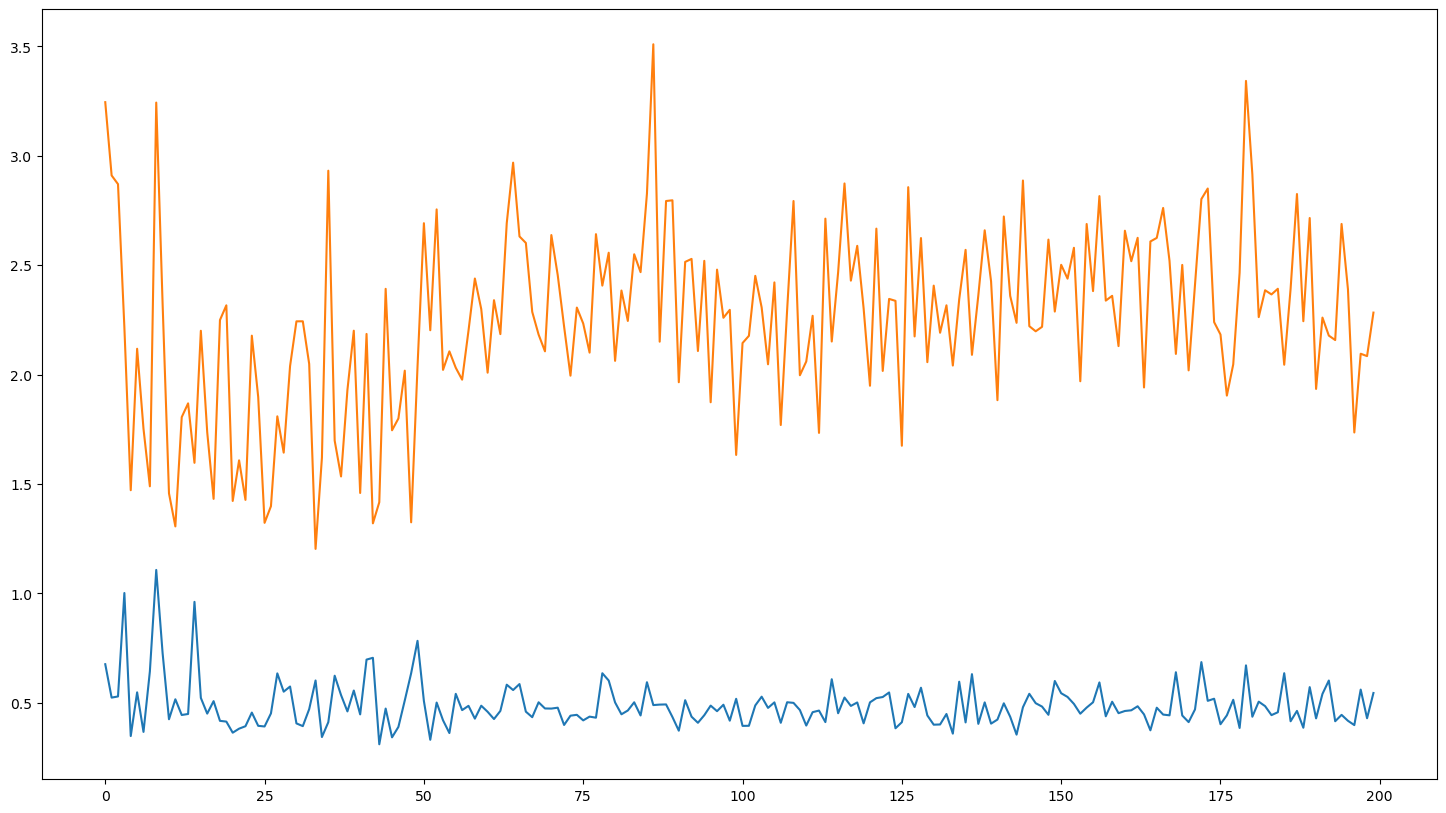

In [116]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_well_formed_ws_online_perturb['Gen_D_KL']))
ax.plot(np.array(Analytic_well_formed_ws_online_perturb['Data_D_KL']))
plt.show()

In [117]:
Analytic_well_formed_ws_online_perturb.to_csv('Analytic_well_formed_ws_online_perturb.csv', index = False)

In [118]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_well_formed_ws_online_perturb',parameters)

### 4. Train with Batch

In [127]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [128]:
data = data.to(dev)
data.shape

torch.Size([12, 905])

In [129]:
data_dist = data_dist.to(dev)
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [130]:
Analytic_well_formed_batch = pd.DataFrame(columns=col_list)
Analytic_well_formed_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4


In [131]:
Phi,Theta = para_init(n_dz,dev)

In [168]:
batch_size = n_data
lr = 0.1
epoch = 80000
gen_batch_size = 50000
n_data

905

In [1]:
# for e in range(epoch):
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,perturb=False)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#     if e%1000 == 0:
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())
#         if e%10000 == 0:
#             gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
#             values_g,counts_g = torch.unique(decimalize(gen_data,dev),return_counts=True)
#             gen_dist = torch.zeros(2**n_d,device=dev)
#             gen_dist[values_g]=counts_g/gen_batch_size

#         stat.append(KL_divergence(gen_dist,data_dist).item())
#         stat.append(KL_divergence(data_dist,gen_dist).item())
        
#         H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,5),dev) # batch_size = 50000
#         H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#         Analytic_well_formed_batch.loc[len(Analytic_well_formed_batch)] = stat

In [170]:
Analytic_well_formed_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.525021,...,4.768372e-07,8.314699,6.931469,5.545174,4.158882,2.079441,0.000305,0.000001,0.000001,4.768372e-07
1,0.683239,0.689525,0.693112,0.689892,0.611669,0.684480,0.691973,0.692236,0.692090,3.769547,...,6.973743e-04,7.407976,6.851051,5.524195,4.155239,2.076885,0.032393,0.009502,0.003829,1.303673e-03
2,0.683113,0.688391,0.689056,0.684273,0.610302,0.680861,0.688621,0.688951,0.686504,3.684549,...,3.224134e-03,7.390837,6.838222,5.510159,4.142100,2.058773,0.039407,0.010944,0.006077,4.882812e-03
3,0.674961,0.687162,0.687696,0.682627,0.603134,0.681687,0.684584,0.685876,0.678284,3.540183,...,6.917953e-03,7.381587,6.841203,5.495172,4.123198,2.030488,0.094495,0.011498,0.008268,9.252071e-03
4,0.667055,0.684914,0.685089,0.663384,0.588889,0.679266,0.683083,0.681753,0.664397,3.303601,...,1.054132e-02,7.372640,6.834558,5.483419,4.112962,2.001640,0.231205,0.012884,0.009548,1.085854e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.254936,0.483671,0.471519,0.362175,0.311054,0.486878,0.538622,0.509707,0.411762,0.841386,...,1.515465e-01,7.332963,5.740113,4.712698,3.221715,1.262097,3.558190,0.830527,0.377091,1.571240e-01
196,0.249736,0.487793,0.482956,0.381998,0.314616,0.489015,0.544008,0.514012,0.430196,0.841386,...,1.511617e-01,7.331681,5.733647,4.704993,3.218552,1.243864,3.554881,0.831907,0.374107,1.546650e-01
197,0.251538,0.499195,0.485637,0.379355,0.307420,0.488974,0.547044,0.516712,0.416601,0.841386,...,1.538165e-01,7.333396,5.713593,4.703431,3.247932,1.251611,3.552602,0.826107,0.380747,1.552300e-01
198,0.244950,0.482813,0.476364,0.349010,0.316451,0.485887,0.543293,0.514981,0.428691,0.841386,...,1.560901e-01,7.330749,5.717417,4.687396,3.253361,1.251109,3.548308,0.828067,0.380471,1.610901e-01


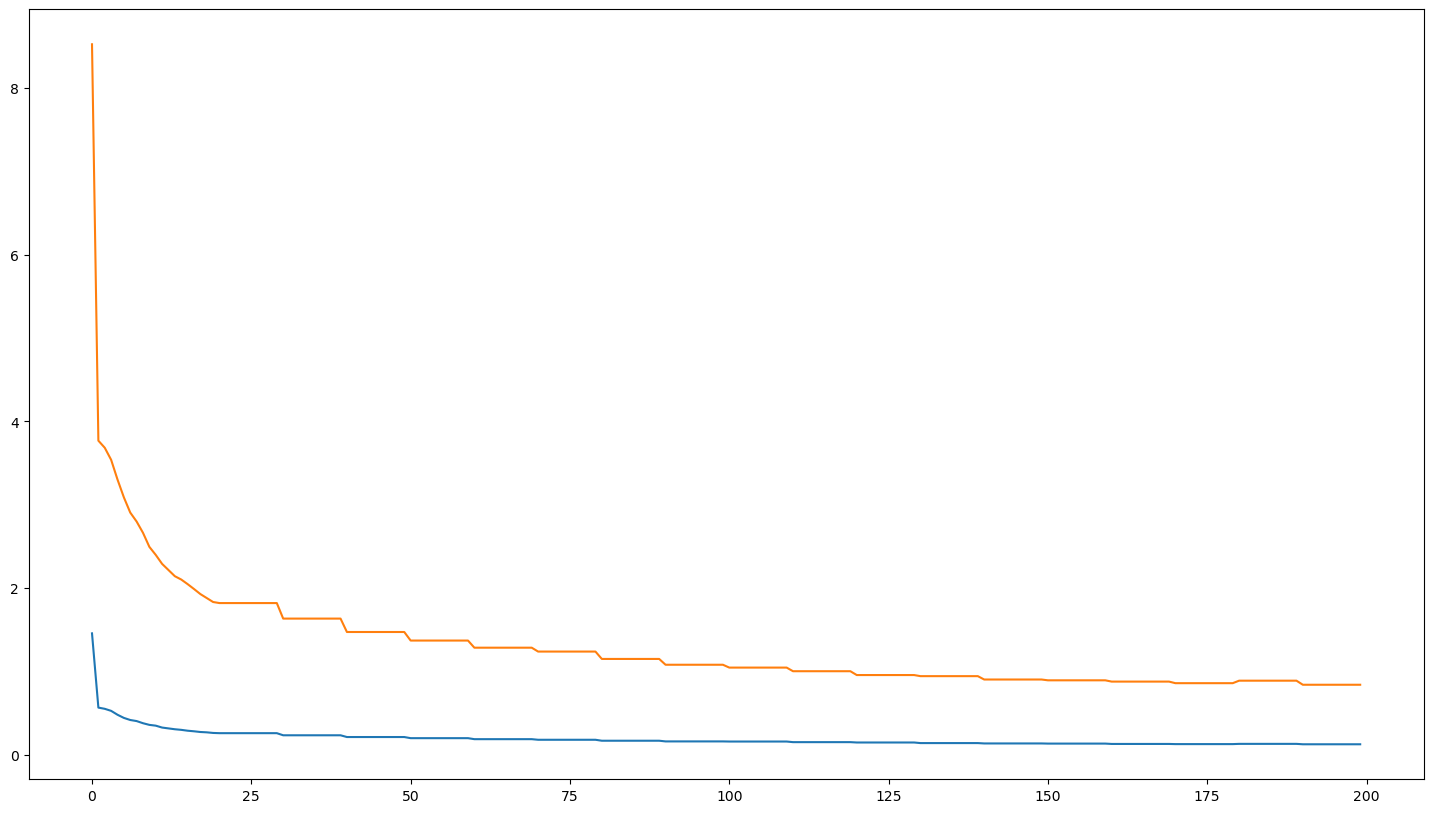

In [171]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_well_formed_batch['Gen_D_KL']))
ax.plot(np.array(Analytic_well_formed_batch['Data_D_KL']))
plt.show()

In [172]:
Analytic_well_formed_batch.to_csv('Analytic_well_formed_batch.csv', index = False)

In [173]:
parameters = {'Phi': Phi, 'Theta': Theta}
np.save('Parameters_well_formed_batch',parameters)

### Plot Analytic

In [46]:
Analytic_well_formed_ws_online_continue = pd.read_csv('Analytic_well_formed_ws_online_continue.csv', sep=",")
Analytic_well_formed_ws_online_MI = pd.read_csv('Analytic_well_formed_ws_online_MI.csv', sep=",")
Analytic_well_formed_ws_online_perturb = pd.read_csv('Analytic_well_formed_ws_online_perturb.csv', sep=",")
Analytic_well_formed_batch = pd.read_csv('Analytic_well_formed_batch.csv', sep=",")

In [57]:
Analytic = Analytic_well_formed_batch
Analytic

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Data_D_KL,...,Recog_I_Layer_4,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_H_Layer_4,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,8.525021,...,4.768372e-07,8.314699,6.931469,5.545174,4.158882,2.079441,0.000305,0.000001,0.000001,4.768372e-07
1,0.683239,0.689525,0.693112,0.689892,0.611669,0.684480,0.691973,0.692236,0.692090,3.769547,...,6.973743e-04,7.407976,6.851051,5.524195,4.155239,2.076885,0.032393,0.009502,0.003829,1.303673e-03
2,0.683113,0.688391,0.689056,0.684273,0.610302,0.680861,0.688621,0.688951,0.686504,3.684549,...,3.224134e-03,7.390837,6.838222,5.510159,4.142100,2.058773,0.039407,0.010944,0.006077,4.882812e-03
3,0.674961,0.687162,0.687696,0.682627,0.603134,0.681687,0.684584,0.685876,0.678284,3.540183,...,6.917953e-03,7.381587,6.841203,5.495172,4.123198,2.030488,0.094495,0.011498,0.008268,9.252071e-03
4,0.667055,0.684914,0.685089,0.663384,0.588889,0.679266,0.683083,0.681753,0.664397,3.303601,...,1.054132e-02,7.372640,6.834558,5.483419,4.112962,2.001640,0.231205,0.012884,0.009548,1.085854e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.254936,0.483671,0.471519,0.362175,0.311054,0.486878,0.538622,0.509707,0.411762,0.841386,...,1.515465e-01,7.332963,5.740113,4.712698,3.221715,1.262097,3.558190,0.830527,0.377091,1.571240e-01
196,0.249736,0.487793,0.482956,0.381998,0.314616,0.489015,0.544008,0.514012,0.430196,0.841386,...,1.511617e-01,7.331681,5.733647,4.704993,3.218552,1.243864,3.554881,0.831907,0.374107,1.546650e-01
197,0.251538,0.499195,0.485637,0.379355,0.307420,0.488974,0.547044,0.516712,0.416601,0.841386,...,1.538165e-01,7.333396,5.713593,4.703431,3.247932,1.251611,3.552602,0.826107,0.380747,1.552300e-01
198,0.244950,0.482813,0.476364,0.349010,0.316451,0.485887,0.543293,0.514981,0.428691,0.841386,...,1.560901e-01,7.330749,5.717417,4.687396,3.253361,1.251109,3.548308,0.828067,0.380471,1.610901e-01


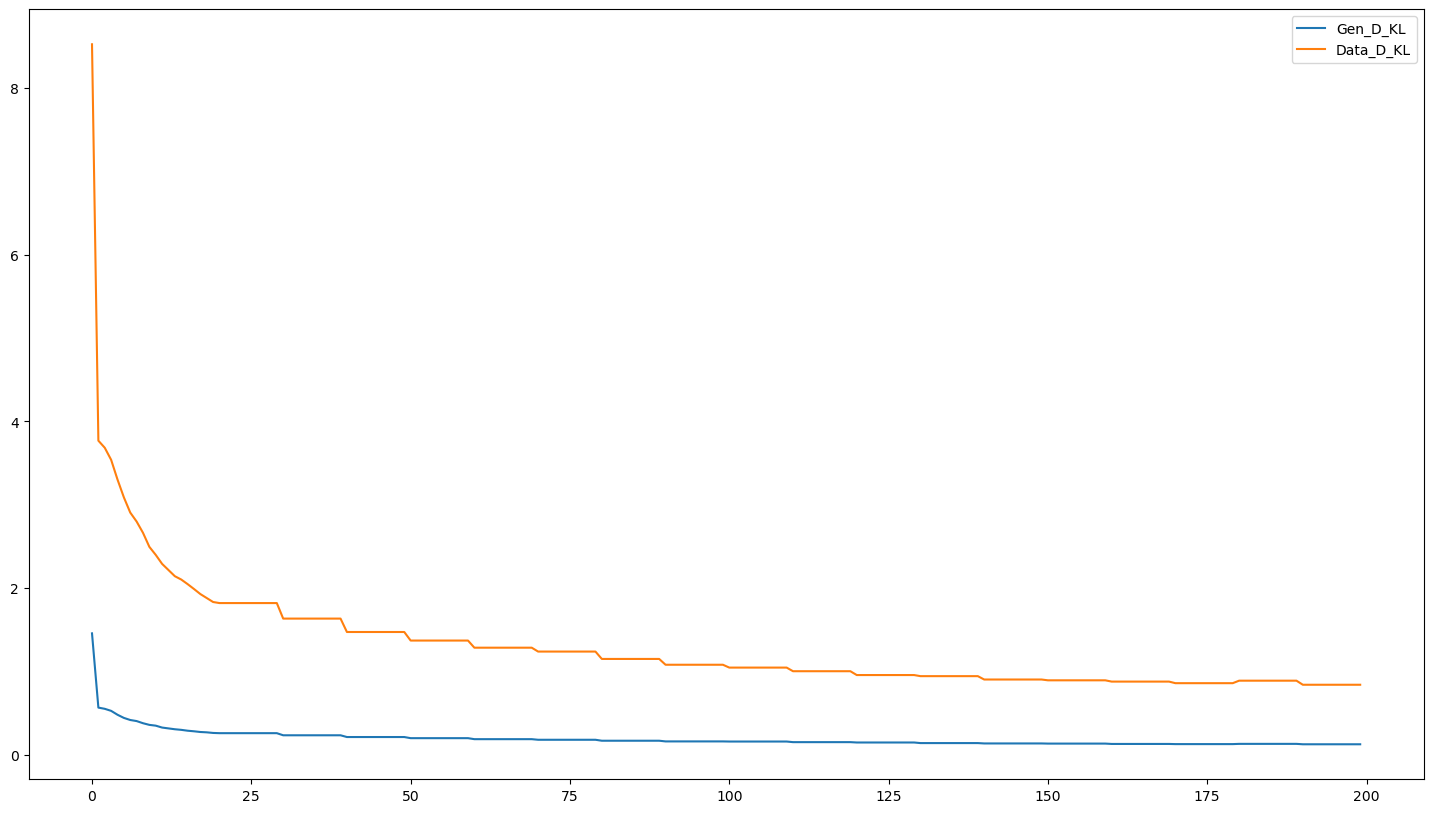

In [58]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
# ax.plot(np.array(Analytic['Data_D_KL'])/np.array(Analytic['Data_D_KL']).mean()*np.array(Analytic['Gen_D_KL']).mean(),label='Data_D_KL')
ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

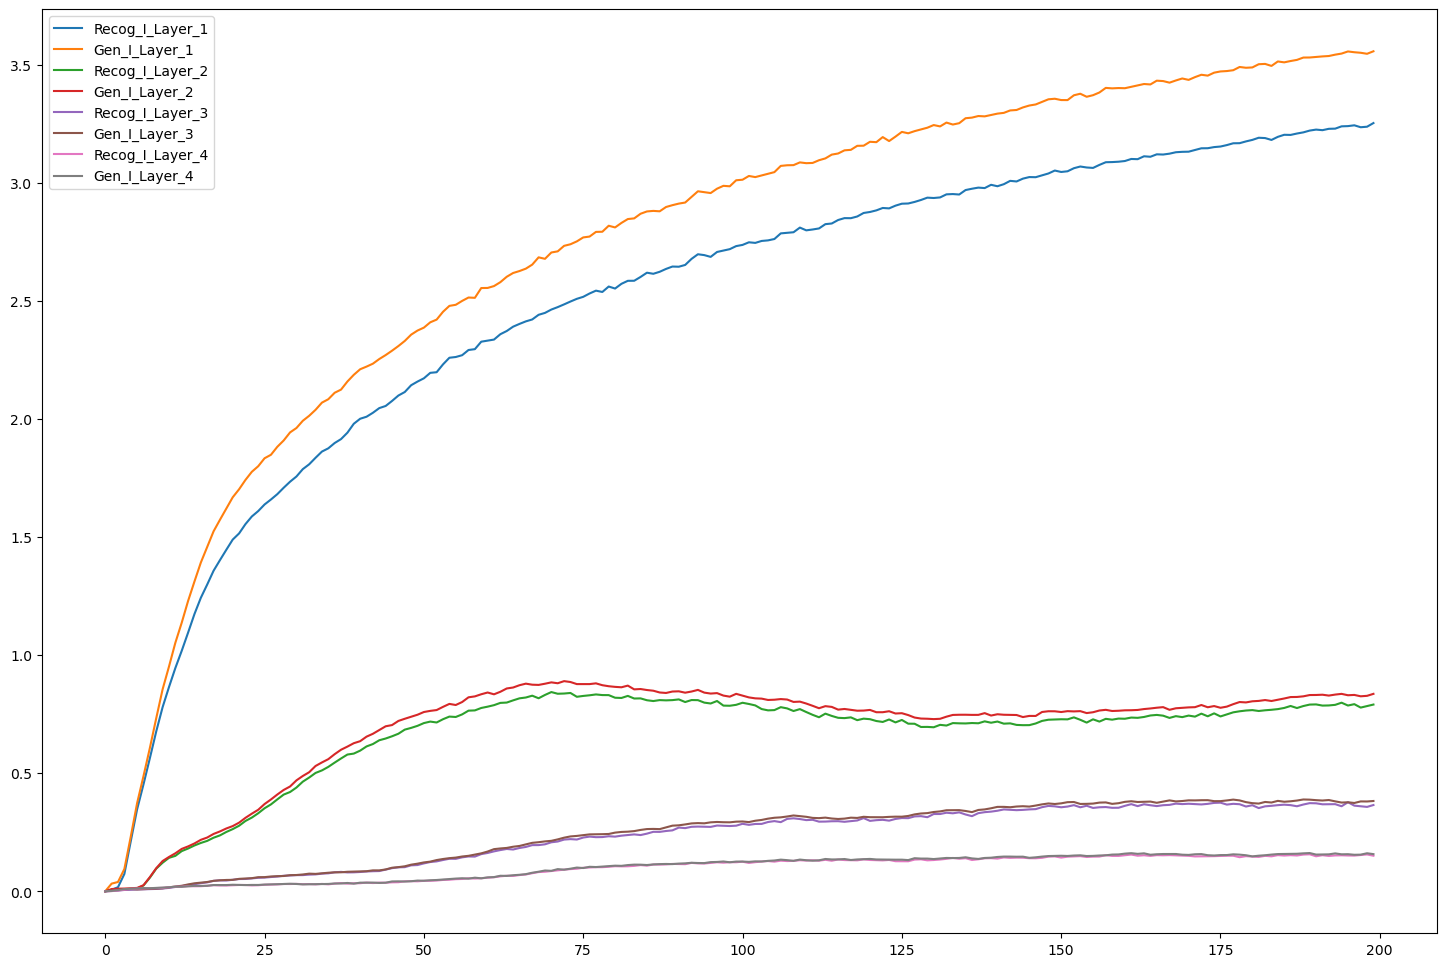

In [49]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

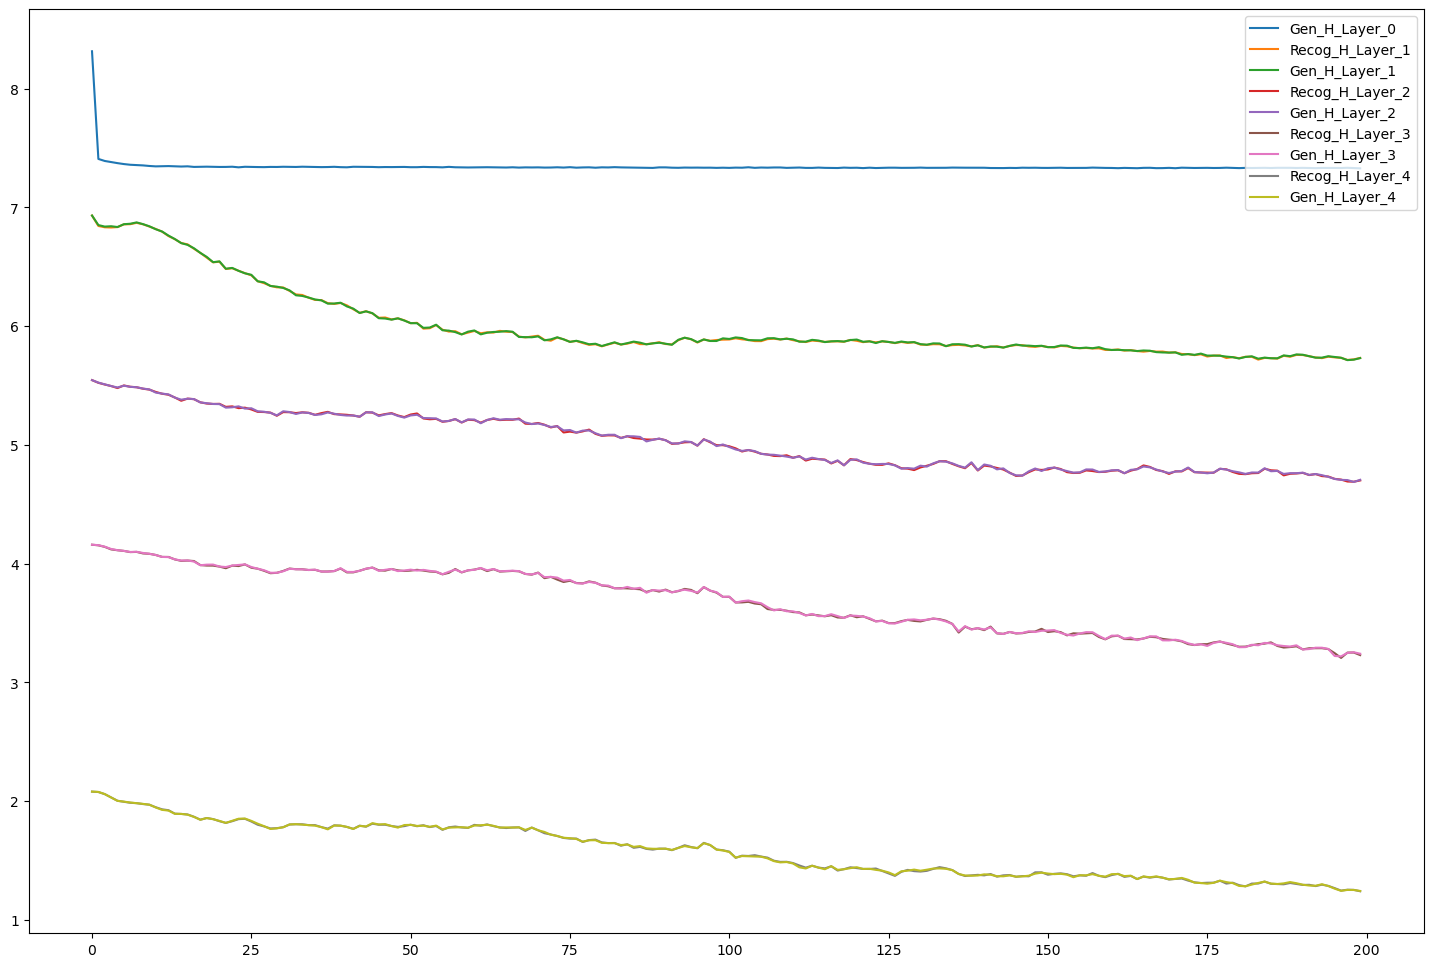

In [50]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [51]:
n_dz * np.log(2)

tensor([8.3178, 6.9315, 5.5452, 4.1589, 2.0794, 0.6931])

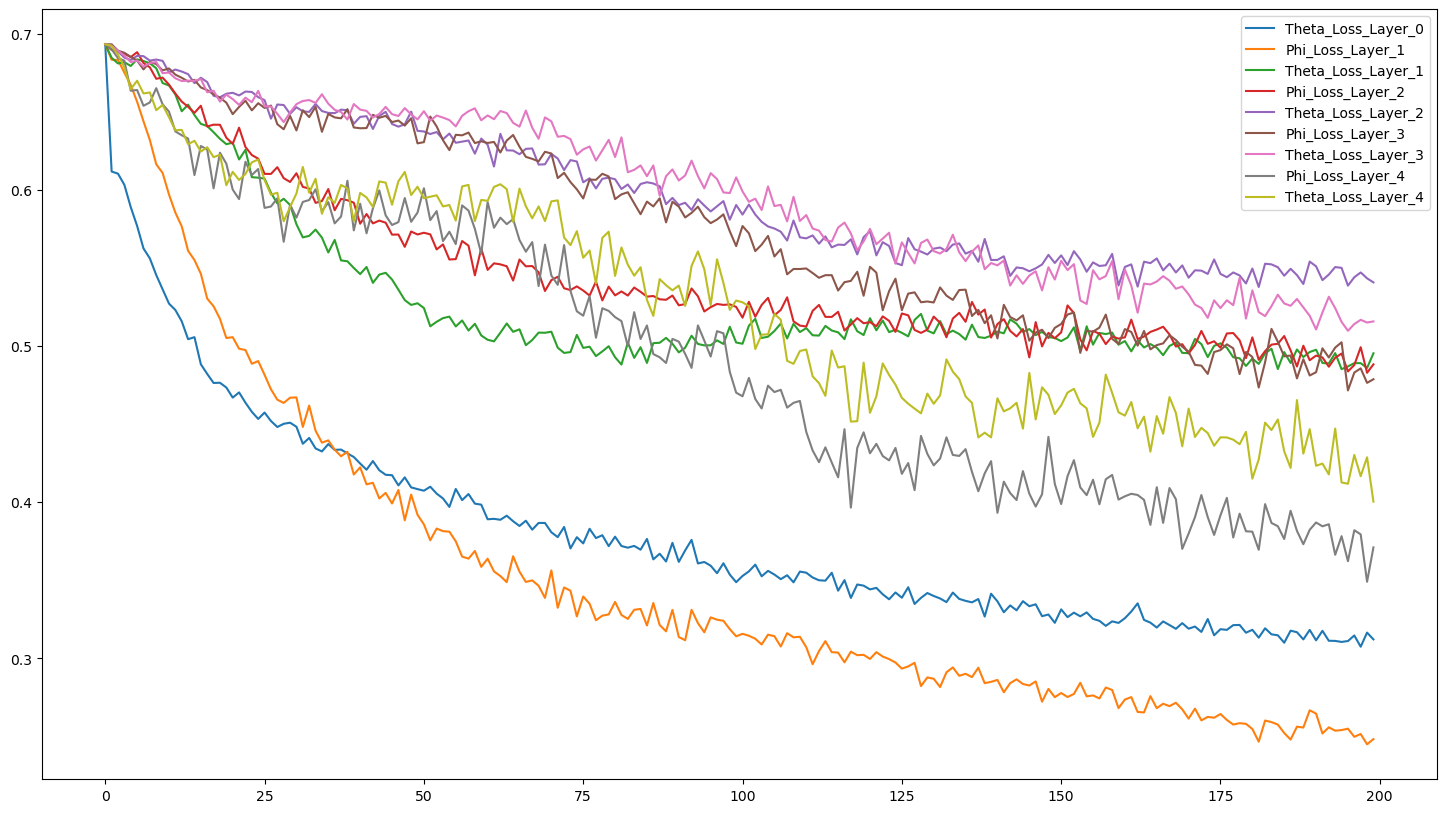

In [52]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

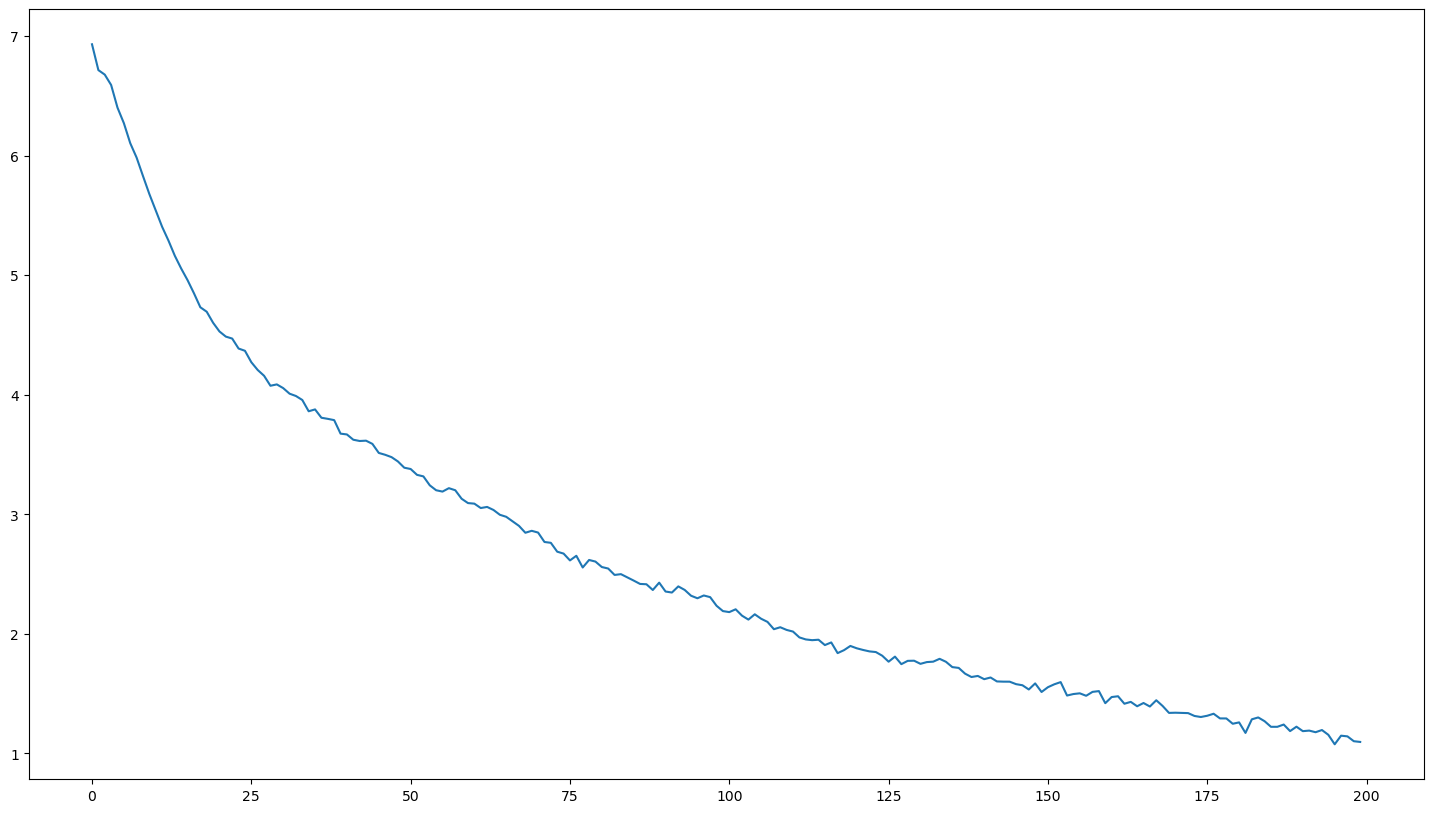

In [53]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

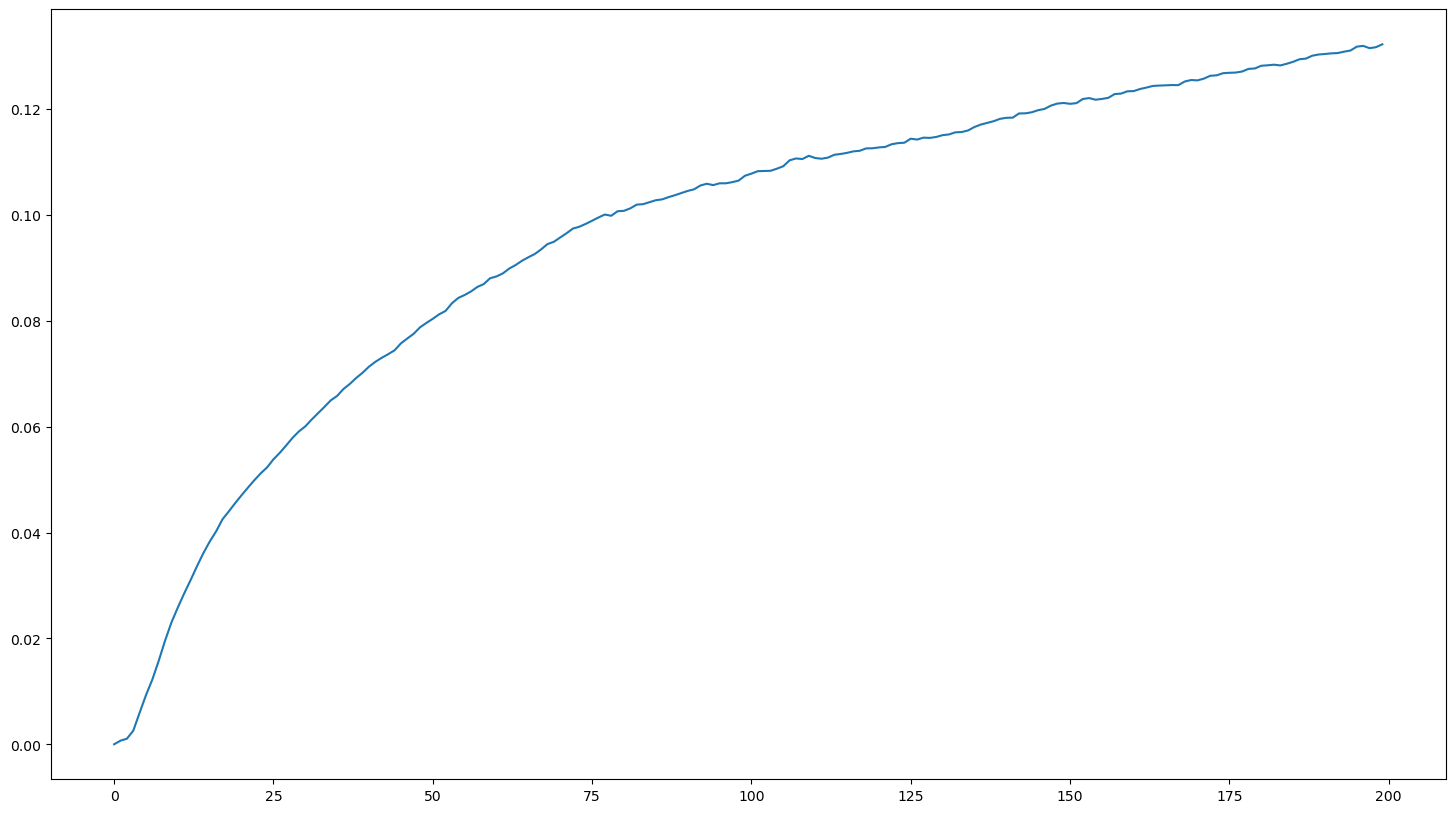

In [54]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()

In [3]:
Table = pd.read_csv('Table_well_formed.csv', sep=",")
Table

,Algorithm,Data_D_KL,Gen_D_KL,Normalized_Loss,Normalized_MI
0,WS,1.790853,0.531887,0.109471,0.196156
1,MIM,1.092877,0.272241,-0.866201,0.289841
2,Ptb,2.393450,0.485752,4.682388,0.075803
3,Batch,0.841386,0.127243,2.282819,0.132242


In [193]:
Table = pd.DataFrame(columns=['Algorithm','Data_D_KL','Gen_D_KL','Normalized_Loss','Normalized_MI'])
Table

,Algorithm,Data_D_KL,Gen_D_KL,Normalized_Loss,Normalized_MI


In [19]:
Analytic = Analytic_well_formed_batch
stat = ['Batch']

In [215]:
# stat = stat + [np.array(Analytic['Data_D_KL'])[-50:].mean(),np.array(Analytic['Gen_D_KL'])[-50:].mean()]
stat = stat + [np.array(Analytic['Data_D_KL'])[-1],np.array(Analytic['Gen_D_KL'])[-1]] # batch
stat

['Batch', 0.8413857221603394, 0.1272432506084442]

In [20]:
Loss = 2*np.array(Analytic['Theta_Loss_Layer_'+str(0)])-((np.array(Analytic['Gen_I_Layer_1']))+ \
                                                         np.array(Analytic['Gen_H_Layer_0']))/structure[0]
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)])+
    np.array(Analytic['Gen_H_Layer_'+str(i)])+np.array(Analytic['Recog_H_Layer_'+str(i)]))/structure[i]/2
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)]+np.array(Analytic['Gen_H_Layer_'+str(n_layer-2)])+ \
                 np.array(Analytic['Recog_H_Layer_'+str(n_layer-2)]))/structure[n_layer-2]/2
stat.append(Loss[-50:].mean())
stat

['Batch', 0.9030809773206708]

In [21]:
Table.at[3,'Normalized_Loss'] = 0.9030809773206708

In [22]:
Table

,Algorithm,Data_D_KL,Gen_D_KL,Normalized_Loss,Normalized_MI
0,WS,1.790853,0.531887,-0.000358,0.196156
1,MIM,1.092877,0.272241,-1.532513,0.289841
2,Ptb,2.393450,0.485752,2.249807,0.075803
3,Batch,0.841386,0.127243,0.903081,0.132242


In [217]:
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
stat.append((I/H)[-50:].mean())
stat

['Batch',
 0.8413857221603394,
 0.1272432506084442,
 2.2828187028566997,
 0.13224210050326551]

In [218]:
Table.loc[len(Table)] = stat
Table

,Algorithm,Data_D_KL,Gen_D_KL,Normalized_Loss,Normalized_MI
0,WS,1.790853,0.531887,0.109471,0.196156
1,MIM,1.092877,0.272241,-0.866201,0.289841
2,Ptb,2.393450,0.485752,4.682388,0.075803
3,Batch,0.841386,0.127243,2.282819,0.132242


In [23]:
Table.to_csv('Table_well_formed.csv', index = False)